# Environment Setup

In [2]:
import io
import os
import shutil
import zipfile
import urllib.request

# Set the working directory
os.chdir('C:/Users/visha/OneDrive/Documents/GitHub/CoAuthorViz_Dashboard')

In [5]:
# Remove existing files and directories
shutil.rmtree('CoAuthorViz')
os.remove('CoAuthorViz.zip')
shutil.rmtree('coauthor-v1.0')
os.remove('chi2022-coauthor-v1.0.zip')

# Download CoAuthorViz.zip
coauthorviz_url = 'https://docs.google.com/uc?export=download&id=1hWDfB9sSObaw7_xCZappNWxFjSeBIicP'
urllib.request.urlretrieve(coauthorviz_url, 'CoAuthorViz.zip')

# Unzip CoAuthorViz.zip
with zipfile.ZipFile('CoAuthorViz.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Download chi2022-coauthor-v1.0.zip
dataset_url = 'https://docs.google.com/uc?export=download&id=1fEri8iScR95v8axe7ZUuTQS20rfpXXLo'
urllib.request.urlretrieve(dataset_url, 'chi2022-coauthor-v1.0.zip')
#dataset_url = 'https://cs.stanford.edu/~minalee/zip/chi2022-coauthor-v1.0.zip'
#urllib.request.urlretrieve(dataset_url, 'chi2022-coauthor-v1.0.zip')

# Unzip chi2022-coauthor-v1.0.zip
with zipfile.ZipFile('chi2022-coauthor-v1.0.zip', 'r') as zip_ref:
    zip_ref.extractall()
#with zipfile.ZipFile('chi2022-coauthor-v1.0.zip', 'r') as zip_ref:
#    zip_ref.extractall()

# Copy .py files from the CoAuthorViz/scripts folder to the current working directory
src_folder = 'CoAuthorViz/scripts'
for file in os.listdir(src_folder):
    if file.endswith('.py'):
        shutil.copy(os.path.join(src_folder, file), os.getcwd())

# Close the files
zip_ref.close()

In [3]:
# Remove existing directories
def change_permissions_recursive(path):
    for root, dirs, files in os.walk(path):
        for directory in dirs:
            os.chmod(os.path.join(root, directory), 0o777)
        for file in files:
            os.chmod(os.path.join(root, file), 0o777)

directory_to_remove = 'nltk_data'
change_permissions_recursive(directory_to_remove)
shutil.rmtree(directory_to_remove)

In [7]:
import subprocess
import requests

# Create a new directory for nltk_data
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
shutil.rmtree(nltk_data_path, ignore_errors=True)
os.makedirs(nltk_data_path, exist_ok=True)

# Clone nltk_data repository
subprocess.run(['git', 'clone', 'https://github.com/nltk/nltk_data.git'])

# Define the URL and the file name for punkt
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/tokenizers/punkt.zip'
file_name = 'punkt.zip'

# Create a new directory for nltk_data
nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
shutil.rmtree(nltk_data_path, ignore_errors=True)
os.makedirs(nltk_data_path, exist_ok=True)

# Download punkt.zip
response = requests.get(url)

# Save the downloaded file
with open(file_name, 'wb') as f:
    f.write(response.content)

# Unzip punkt.zip
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(nltk_data_path, 'tokenizers'))

# Remove the downloaded file
os.remove(file_name)

# Update nltk.data.path
import nltk
nltk.data.path.append(os.path.join(os.path.expanduser('~'), 'nltk_data'))

# Importing Libraries

In [4]:
from tqdm import tqdm
import pandas as pd
import nltk
from nltk import word_tokenize
import string
import numpy as np
import matplotlib.pyplot as plt
from utils import load_sessions, read_session
from main import generate_buffer
from events import generate_event_seq
from summary import stats
from collections import defaultdict

In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.cluster.hierarchy import ClusterWarning

# Suppressing specific warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", ClusterWarning)

# Creating Sequence Dataframe

In [6]:
import os

nltk_data_path = os.path.join(os.path.expanduser('~'), 'nltk_data')
print(os.listdir(nltk_data_path))

['tokenizers']


In [7]:
sessions = load_sessions()
# sessions = load_sessions()[:10]
file_name = []
text = []
sentence_metrics_list = []
api_metrics_list = []
err = []

# Creating a DataFrame
df = pd.DataFrame(list(zip(file_name, text, sentence_metrics_list, api_metrics_list)),
                  columns=["file_name", "text", "sentence_metrics", "api_metrics"])


# Adding a defaultdict to store action sequences
action_sequences = defaultdict(list)

for sess in tqdm(sessions):
    events = read_session(sess, verbose=0)
    try:
        text_buffer = generate_buffer(events)
    except:
        err.append(str(sess.split('/')[-1]) + " is throwing an error!")
        continue

    file_id = os.path.basename(sess).split('.')[0]
    file_name.append(file_id)
    text.append(text_buffer[-1])
    event_seq_dict = generate_event_seq(buffer=text_buffer,
                                        events=events)
    sentence_metrics, api_metrics = stats(event_seq_dict)

    for num_sent, seq in zip(event_seq_dict['num_sent'], event_seq_dict['sequence']):
        action_sequences[file_id].append((num_sent, seq))

    sentence_metrics_list.append(sentence_metrics)
    api_metrics_list.append(api_metrics)

# Creating a DataFrame
df = pd.DataFrame(list(zip(file_name, text, sentence_metrics_list, api_metrics_list)),
                  columns=["file_name", "text", "sentence_metrics", "api_metrics"])

# Saving action sequences to a new DataFrame column
df["action_sequences"] = df["file_name"].apply(lambda x: action_sequences[x])

Successfully downloaded 120 writing sessions in CoAuthor!


100%|██████████| 120/120 [01:26<00:00,  1.39it/s]


In [ ]:
# df.to_csv("df_init.csv")

In [8]:
df

file_name  \
0    0822cf8998be4c44962989a70f00eb9e   
1    0c3f03f1c5a44e4bbe66a5c9571797d9   
2    11914c731ffe464791f9cb2b375f4d70   
3    11e8186be4314e93852c7677b430fba3   
4    126ae6528ba141a58f932a3ed097b47e   
..                                ...   
115  f84a83053e004acb9ccc912f7c6d8ec6   
116  f8e0496b35c64e35b500e2034493eb8e   
117  fbd087c5c3ab48f1b6540c80976e3285   
118  fdd85d76a9eb42d994e75ce952202309   
119  ffa97e9f02214fdaad83cabea410c1d9   

                                                  text  \
0    Humans once wielded formidable magical power. ...   
1    An alien has kidnapped Matt Damon, not knowing...   
2    Is Listening to a Book Just as Good as Reading...   
3    Your entire life, you've been told you're deat...   
4    All of the "#1 Dad" mugs in the world changed ...   
..                                                 ...   
115  Humans once wielded formidable magical power. ...   
116  When you're 28, science discovers a drug that ...   
117  An alien has kidnapped Matt Damon, not knowing...   
118  Is Listening to a Book Just as Good as Reading...   
119  What Stereotypical Characters Make You Cringe?...   

                                      sentence_metrics  \
0    {'Total number of sentences': 25, 'Number of s...   
1    {'Total number of sentences': 18, 'Number of s...   
2    {'Total number of sentences': 15, 'Number of s...   
3    {'Total number of sentences': 36, 'Number of s...   
4    {'Total number of sentences': 21, 'Number of s...   
..                                                 ...   
115  {'Total number of sentences': 25, 'Number of s...   
116  {'Total number of sentences': 17, 'Number of s...   
117  {'Total number of sentences': 16, 'Number of s...   
118  {'Total number of sentences': 21, 'Number of s...   
119  {'Total number of sentences': 22, 'Number of s...   

                                           api_metrics  \
0    {'Total number of GPT-3 calls made': 24, 'Numb...   
1    {'Total number of GPT-3 calls made': 10, 'Numb...   
2    {'Total number of GPT-3 calls made': 4, 'Numbe...   
3    {'Total number of GPT-3 calls made': 30, 'Numb...   
4    {'Total number of GPT-3 calls made': 6, 'Numbe...   
..                                                 ...   
115  {'Total number of GPT-3 calls made': 15, 'Numb...   
116  {'Total number of GPT-3 calls made': 11, 'Numb...   
117  {'Total number of GPT-3 calls made': 6, 'Numbe...   
118  {'Total number of GPT-3 calls made': 7, 'Numbe...   
119  {'Total number of GPT-3 calls made': 10, 'Numb...   

                                      action_sequences  
0    [(3, [prompt, user]), (4, [user, empty-call, u...  
1    [(1, [prompt, user]), (2, [gpt3-call, user]), ...  
2    [(7, [prompt, user]), (8, [gpt3-call, modify-g...  
3    [(4, [prompt, user]), (5, [user]), (6, [gpt3-c...  
4    [(1, [prompt, user]), (2, [user]), (3, [gpt3-c...  
..                                                 ...  
115  [(3, [prompt, user]), (4, [user]), (5, [gpt3-c...  
116  [(3, [prompt, user]), (4, [user]), (5, [user, ...  
117  [(1, [prompt, user]), (2, [user]), (3, [gpt3-c...  
118  [(7, [prompt, user]), (8, [gpt3-call, user]), ...  
119  [(4, [prompt, user]), (5, [gpt3-call, user]), ...  

[120 rows x 5 columns]

In [9]:
df.to_csv('df.csv', index=False)

In [10]:
# df1 = pd.read_csv("df_init.csv").drop("Unnamed: 0", axis=1)

In [11]:
# df1

In [9]:
# Converting action sequences to a dictionary containing only sentence number and the sequence
def action_seq_to_dict(action_sequences):
    sentence_action_dict = {}

    for sentence_num, action_sequence in action_sequences:
        if sentence_num not in sentence_action_dict:
            sentence_action_dict[sentence_num] = []

        sentence_action_dict[sentence_num].extend(action_sequence)

    return sentence_action_dict

In [10]:
# Adding the dictionary to the dataframe
df['sentence_action_dict'] = df['action_sequences'].apply(action_seq_to_dict)

In [14]:
# Installing the pm4py and graphviz package for the process mining
#%pip install pm4py
#%pip install graphviz

In [11]:
# Importing required libraries
import pm4py
from pm4py.objects.log.obj import EventLog, Trace, Event

In [12]:
# Creating an event log to record the events in a proper format for use in inductive miner
def create_event_log(sentence_action_dict):
    event_log = EventLog()

    for sentence_num, actions in sentence_action_dict.items():
        trace = Trace()
        trace.attributes["concept:name"] = f"Sentence {sentence_num}"

        for action in actions:
            event = Event()
            event["concept:name"] = action
            trace.append(event)

        event_log.append(trace)

    return event_log

In [13]:
# Adding the event log to the dataframe
df['event_log'] = df['sentence_action_dict'].apply(create_event_log)

In [14]:
# Perform the inductive mining
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

df['process_model'] = df['event_log'].apply(lambda log: inductive_miner.apply(log))

In [16]:
# Creating Process Trees for each process model generated for a session
from pm4py.visualization.process_tree import visualizer as pt_visualizer

# Set the working directory to the Process_Trees folder
os.chdir('C:/Users/visha/OneDrive/Documents/GitHub/CoAuthorViz_Dashboard/CoAuthorViz/Process_Trees')

# Remove existing .png files
for file in os.listdir():
    if file.endswith('.png'):
        os.remove(file)

# Create and save process trees for each process model
for index, row in df.iterrows():
    gviz = pt_visualizer.apply(row['process_model'])
    pt_visualizer.save(gviz, f"process_model_{index}.png")

# Change back to the main working directory (if needed)
os.chdir('C:/Users/visha/OneDrive/Documents/GitHub/CoAuthorViz_Dashboard')

In [17]:
# Creating Digraphs
import networkx as nx

def process_tree_to_digraph(tree):
    graph = nx.DiGraph()
    nodes = [tree]
    edges = []

    while nodes:
        node = nodes.pop(0)
        if node.children:
            for child in node.children:
                edges.append((node, child))
                nodes.append(child)

    graph.add_edges_from(edges)
    return graph

In [18]:
# Calculating the digraph similarity
def digraph_similarity(graph1, graph2):
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())
    
    intersection = len(edges1.intersection(edges2))
    union = len(edges1.union(edges2))
    
    return intersection / union

In [19]:
# Applying it to each process models and producing digraphs in the dataframe
df['digraph'] = df['process_model'].apply(process_tree_to_digraph)

In [20]:
# Calculating the similarity matrix
n = len(df)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            similarity_matrix[i, j] = 1.0
        elif i < j:
            similarity_matrix[i, j] = digraph_similarity(df.loc[i, 'digraph'], df.loc[j, 'digraph'])
            similarity_matrix[j, i] = similarity_matrix[i, j]

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Converting similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix

# Ensuring diagonal elements are zero
np.fill_diagonal(distance_matrix, 0)

# Finding the optimal epsilon value for DBSCAN
eps_values = np.arange(0.1, 1, 0.05)
best_eps = None
best_silhouette = -1

for eps in eps_values:
    clustering = DBSCAN(eps=eps, metric='precomputed', min_samples=2).fit(distance_matrix)
    labels = clustering.labels_
    
    # Ignore -1 labels since they represent noise points
    mask = labels != -1
    filtered_labels = labels[mask]
    filtered_distance_matrix = distance_matrix[mask][:, mask]

    if len(set(filtered_labels)) > 1:
        silhouette = silhouette_score(filtered_distance_matrix, filtered_labels, metric='precomputed')
        
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_eps = eps

# Performing DBSCAN clustering with the optimal epsilon value
clustering = DBSCAN(eps=best_eps, metric='precomputed', min_samples=8).fit(distance_matrix)
labels = clustering.labels_

# Printing the clustering results
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)
print(f"Number of clusters: {num_clusters}")
for i in range(num_clusters):
    print(f"Cluster {i + 1}: {np.where(labels == i)[0]}")

Number of clusters: 2
Cluster 1: [  2  14  53  59  77  78 100 102 110 113 114]
Cluster 2: [  7  27  46  58  70  82  98 108 116 119]


In [22]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN

min_samples = 8

# Running DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
labels = dbscan.fit_predict(similarity_matrix)

# Excluding noise points from the evaluation (noise points have a label of -1)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
non_noise_labels = labels[core_samples_mask]

# Removing noise points from the similarity matrix as well
non_noise_distance_matrix = distance_matrix[np.ix_(core_samples_mask, core_samples_mask)]

# Calculating the Silhouette Score
sil_score = silhouette_score(non_noise_distance_matrix, non_noise_labels, metric='precomputed')
print(f'Silhouette Score: {sil_score}')

# Calculating the Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(non_noise_distance_matrix, non_noise_labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

Silhouette Score: 1.0
Calinski-Harabasz Index: 1.0


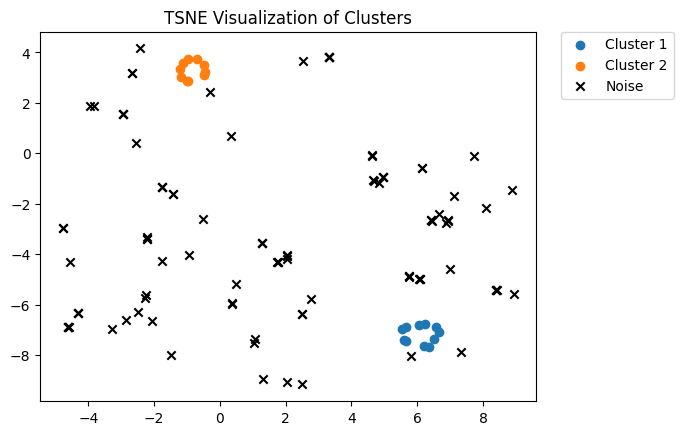

In [23]:
from sklearn.manifold import TSNE

# Performing t-SNE to reduce the dimensionality to 2D
embedding = TSNE(n_components=2, metric='precomputed', init='random').fit_transform(distance_matrix)

# Plotting the clusters
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)

for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    plt.scatter(embedding[cluster_indices, 0], embedding[cluster_indices, 1], label=f'Cluster {i + 1}')

# Plotting noise points as a separate cluster
if -1 in unique_labels:
    noise_indices = np.where(labels == -1)[0]
    plt.scatter(embedding[noise_indices, 0], embedding[noise_indices, 1], label='Noise', marker='x', c='black')

plt.title("TSNE Visualization of Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [27]:
# Installing UMAP library
#%pip install umap-learn

c:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\visha\AppData\Local\Programs\Python\Python3

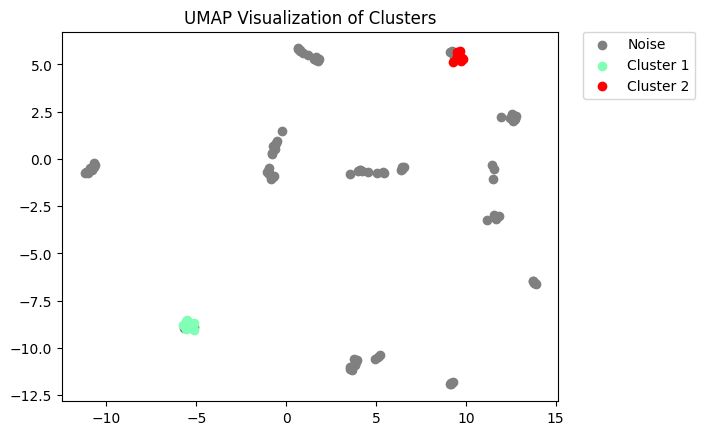

In [24]:
import umap

# Perform dimensionality reduction using UMAP
reducer = umap.UMAP(metric='precomputed', n_neighbors=5, random_state=42)
embedding = reducer.fit_transform(distance_matrix)

# Plot the clusters
unique_labels = np.unique(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points
        color = 'gray'

    mask = labels == label
    x, y = embedding[mask].T
    plt.scatter(x, y, color=color, label=f"Cluster {label + 1}" if label != -1 else "Noise")

plt.title("UMAP Visualization of Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [29]:
# Set the working directory to the Process_Trees folder
#os.chdir('C:/Users/visha/OneDrive/Documents/GitHub/CoAuthorViz Dashboard/hdbscan-0.8.29-1')
#!pip install Cython
#!python setup.py install

In [25]:
import hdbscan
from sklearn.metrics import silhouette_score

# Converting similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix

# Ensuring diagonal elements are zero
np.fill_diagonal(distance_matrix, 0)

# Performing HDBSCAN clustering
clustering = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=8, cluster_selection_epsilon=0.1).fit(distance_matrix)
labels = clustering.labels_

      # Ignore -1 labels since they represent noise points
mask = labels != -1
filtered_labels = labels[mask]
filtered_distance_matrix = distance_matrix[mask][:, mask]

# Calculating silhouette score
if len(set(filtered_labels)) > 1:
    silhouette = silhouette_score(filtered_distance_matrix, filtered_labels, metric='precomputed')
    print(f"Silhouette score: {silhouette}")

# Printing the clustering results
unique_labels = np.unique(labels)
num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)
print(f"Number of clusters: {num_clusters}")
for i in range(num_clusters):
    print(f"Cluster {i + 1}: {np.where(labels == i)[0]}")

Silhouette score: 0.5939551109720909
Number of clusters: 5
Cluster 1: [  7  10  27  46  58  70  75  80  82  98 108 116 119]
Cluster 2: [15 18 29 30 43 56 62 76 81 88 92 95 99]
Cluster 3: [  1  37  51  55  64  66  72  79  96 109]
Cluster 4: [ 4 21 31 35 44 48 71 94]
Cluster 5: [  2  14  34  50  53  59  63  65  74  77  78  90  91 100 102 110 113 114
 117]


In [26]:
# Defining a range of cluster numbers to test
cluster_range = range(2, 80)

# Initializing lists to store the evaluation metrics for K-means and Agglomerative Hierarchical clustering
kmeans_elbow = []
kmeans_silhouette = []
kmeans_calinski = []
agglo_silhouette = []
agglo_calinski = []

In [27]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering

for k in cluster_range:
    # K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_clusters = kmeans.fit_predict(distance_matrix)

    # Agglomerative Hierarchical clustering
    agglo = AgglomerativeClustering(n_clusters=k)
    agglo_clusters = agglo.fit_predict(distance_matrix)

    # Evaluation metrics
    kmeans_elbow.append(kmeans.inertia_)
    kmeans_silhouette.append(silhouette_score(distance_matrix, kmeans_clusters))
    kmeans_calinski.append(calinski_harabasz_score(distance_matrix, kmeans_clusters))
    agglo_silhouette.append(silhouette_score(distance_matrix, agglo_clusters))
    agglo_calinski.append(calinski_harabasz_score(distance_matrix, agglo_clusters))

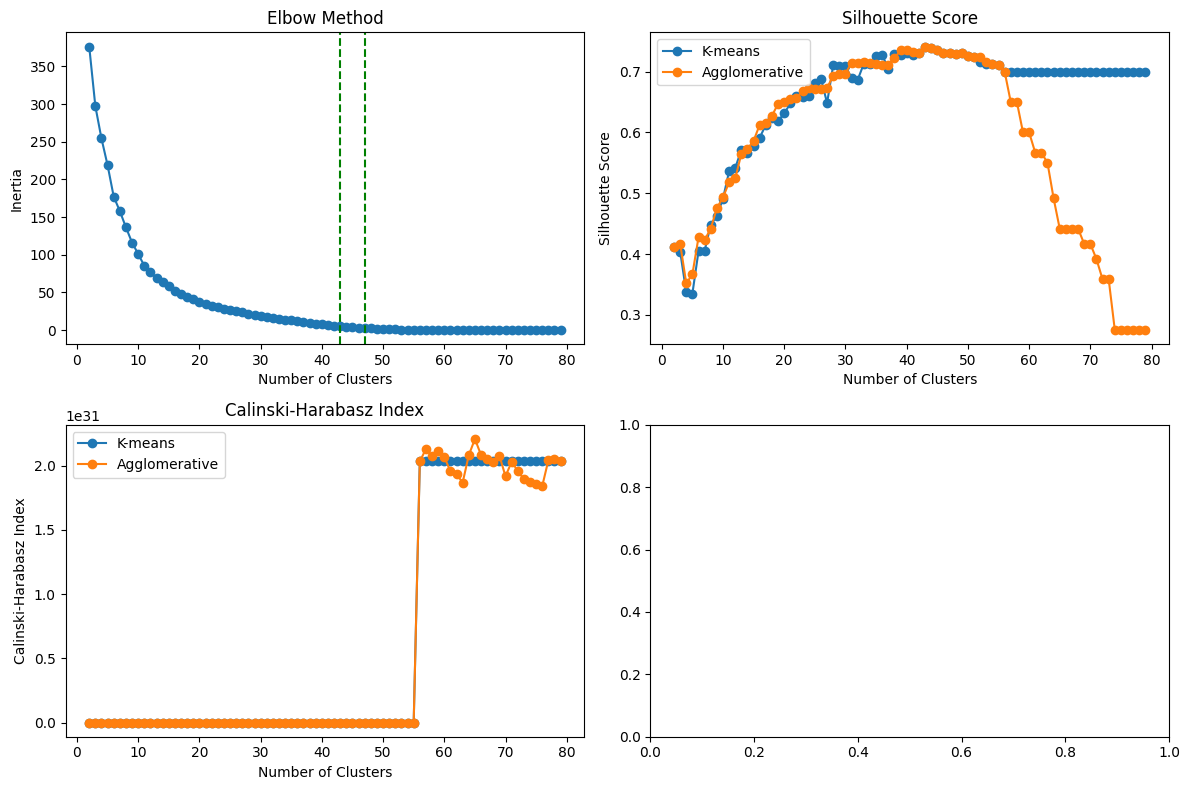

In [28]:
# Plotting the evaluation metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(cluster_range, kmeans_elbow, 'o-', label='K-means')
axs[0, 0].set_title('Elbow Method')
axs[0, 0].set_xlabel('Number of Clusters')
axs[0, 0].set_ylabel('Inertia')

axs[0, 1].plot(cluster_range, kmeans_silhouette, 'o-', label='K-means')
axs[0, 1].plot(cluster_range, agglo_silhouette, 'o-', label='Agglomerative')
axs[0, 1].set_title('Silhouette Score')
axs[0, 1].set_xlabel('Number of Clusters')
axs[0, 1].set_ylabel('Silhouette Score')

axs[1, 0].plot(cluster_range, kmeans_calinski, 'o-', label='K-means')
axs[1, 0].plot(cluster_range, agglo_calinski, 'o-', label='Agglomerative')
axs[1, 0].set_title('Calinski-Harabasz Index')
axs[1, 0].set_xlabel('Number of Clusters')
axs[1, 0].set_ylabel('Calinski-Harabasz Index')

# Adding legends
axs[0, 1].legend()
axs[1, 0].legend()

# Adding vertical lines
axs[0, 0].axvline(x=43, color='g', linestyle='--')
axs[0, 0].axvline(x=47, color='g', linestyle='--')

# Adjusting layout and displaying plots
plt.tight_layout()
plt.show()

In [29]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode

# Converting similarity matrix to distance matrix
distance_matrix = 1 - similarity_matrix

# Ensuring diagonal elements are zero
np.fill_diagonal(distance_matrix, 0)

# Performing K-means clustering
n_clusters = 47
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(distance_matrix)

# Performing DBSCAN clustering
clustering = DBSCAN(eps=0.1, metric='precomputed', min_samples=10).fit(distance_matrix)
dbscan_labels = clustering.labels_

# Mapping DBSCAN noise points (-1) to a new cluster label
noise_label = max(kmeans_labels) + 1
dbscan_labels[dbscan_labels == -1] = noise_label

# Combining clustering results for ensemble clustering
combined_labels = np.stack((kmeans_labels, dbscan_labels), axis=-1)

# Majority vote function
def majority_vote(labels):
    return mode(labels).mode[0]

# Computing consensus clustering
consensus_labels = np.apply_along_axis(majority_vote, 1, combined_labels)

# Printing the clustering results
unique_labels = np.unique(consensus_labels)
num_clusters = len(unique_labels)
print(f"Number of clusters: {num_clusters}")
for i in range(num_clusters):
    print(f"Cluster {i + 1}: {np.where(consensus_labels == i)[0]}")

Number of clusters: 46
Cluster 1: [  2  14  51  53  59  77  78 100 102 109 110 113 114]
Cluster 2: [  7  27  46  58  70  82  87  98 108 116 119]
Cluster 3: []
Cluster 4: [106]
Cluster 5: [90]
Cluster 6: [ 28  42  45 115]
Cluster 7: [33 49 60]
Cluster 8: [ 40  86 105]
Cluster 9: [ 52  67 107]
Cluster 10: [ 38  61 101 103]
Cluster 11: [15 56 76]
Cluster 12: [ 4 31 35 44 48 71 94]
Cluster 13: [ 34  63  65  74  91 117]
Cluster 14: [32]
Cluster 15: [6]
Cluster 16: [10 75]
Cluster 17: [73]
Cluster 18: [ 1 37 55 64 66 79]
Cluster 19: [ 68 104]
Cluster 20: [18 62 81]
Cluster 21: [ 0 16]
Cluster 22: [17 19 84]
Cluster 23: [69]
Cluster 24: [29 30 43 92 95 99]
Cluster 25: [54]
Cluster 26: [24 93]
Cluster 27: [ 22  89 111 118]
Cluster 28: [ 5 20]
Cluster 29: [36]
Cluster 30: [41]
Cluster 31: [57]
Cluster 32: [23]
Cluster 33: [11]
Cluster 34: [112]
Cluster 35: [13]
Cluster 36: [88]
Cluster 37: [72 96]
Cluster 38: [39]
Cluster 39: [25]
Cluster 40: [ 8 83 97]
Cluster 41: [3]
Cluster 42: [21 85]
Clust

c:\Users\visha\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


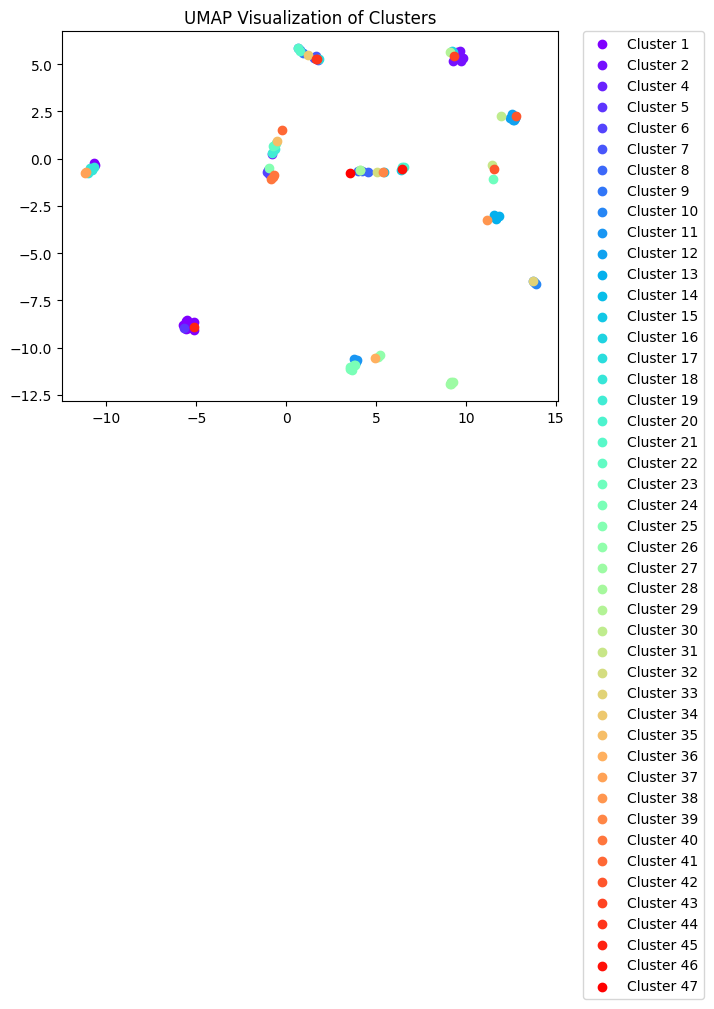

In [30]:
import umap

# Performing dimensionality reduction using UMAP
reducer = umap.UMAP(metric='precomputed', n_neighbors=5, random_state=42)
embedding = reducer.fit_transform(distance_matrix)

# Plotting the clusters
unique_labels = np.unique(consensus_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == noise_label:
        # Noise points
        color = 'gray'

    mask = consensus_labels == label
    x, y = embedding[mask].T
    plt.scatter(x, y, color=color, label=f"Cluster {label + 1}" if label != noise_label else "Noise")

plt.title("UMAP Visualization of Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [31]:
# Adding the cluster points to the dataframe
df['cluster'] = consensus_labels

In [32]:
df.cluster.unique()

array([20, 17,  0, 40, 11, 27, 14,  1, 39, 43, 15, 32, 46, 34, 10, 21, 19,
       41, 26, 31, 25, 38, 45,  5, 23, 13,  6, 12, 28,  9, 37,  7, 29, 44,
        8, 24, 30, 18, 22, 36, 16, 42, 35,  4,  3, 33], dtype=int64)

In [33]:
cluster_counts = df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']
print(cluster_counts)

    cluster  count
0         0     13
1         1     11
2        11      7
3        17      6
4        23      6
5        12      6
6         5      4
7         9      4
8        26      4
9        39      3
10        8      3
11        6      3
12       10      3
13       21      3
14       19      3
15        7      3
16       25      2
17       18      2
18       36      2
19       20      2
20       41      2
21       15      2
22       43      2
23       27      2
24       31      1
25       24      1
26        3      1
27        4      1
28       35      1
29       42      1
30       16      1
31       40      1
32       22      1
33       30      1
34       44      1
35       14      1
36       38      1
37       29      1
38       37      1
39       28      1
40       32      1
41       46      1
42       13      1
43       34      1
44       45      1
45       33      1


In [34]:
from collections import Counter

def get_most_common_digraph_and_model(cluster_df):
    digraph_counter = Counter(cluster_df['digraph'])
    process_model_counter = Counter(cluster_df['process_model'])

    most_common_digraph = digraph_counter.most_common(1)[0][0]
    most_common_process_model = process_model_counter.most_common(1)[0][0]

    return most_common_digraph, most_common_process_model

# Grouping the dataframe by cluster
grouped_df = df.groupby('cluster')

# Finding the most common digraph and process model for each cluster
for cluster, group in grouped_df:
    most_common_digraph, most_common_process_model = get_most_common_digraph_and_model(group)
    print(f"Cluster {cluster}:")
    print("Most common DiGraph:")
    print(most_common_digraph)
    print("Most common Process Model:")
    print(most_common_process_model)
    print("\n")

Cluster 0:
Most common DiGraph:
DiGraph with 12 nodes and 12 edges
Most common Process Model:
->( X( tau, X( 'prompt', ->( 'gpt3-call', X( tau, 'modify-gpt3' ) ) ) ), *( 'user', 'empty-call' ) )


Cluster 1:
Most common DiGraph:
DiGraph with 11 nodes and 12 edges
Most common Process Model:
->( X( tau, X( 'prompt', 'gpt3-call' ) ), *( ->( 'user', X( tau, 'empty-call' ) ), tau ) )


Cluster 3:
Most common DiGraph:
DiGraph with 14 nodes and 16 edges
Most common Process Model:
->( X( tau, X( 'prompt', ->( 'gpt3-call', X( tau, 'modify-gpt3' ) ) ) ), X( tau, *( 'user', *( 'empty-call', tau ) ) ) )


Cluster 4:
Most common DiGraph:
DiGraph with 13 nodes and 14 edges
Most common Process Model:
X( tau, ->( X( tau, X( 'prompt', ->( 'gpt3-call', X( tau, 'modify-gpt3' ) ) ) ), *( 'user', 'empty-call' ) ) )


Cluster 5:
Most common DiGraph:
DiGraph with 16 nodes and 20 edges
Most common Process Model:
->( X( tau, X( 'prompt', ->( *( 'gpt3-call', tau ), X( tau, 'modify-gpt3' ) ) ) ), X( tau, *( ->( 

In [40]:
# %pip install scikit-learn-extra

                                              0.0/340.5 kB ? eta -:--:--
     ------------------------------------  337.9/340.5 kB 10.6 MB/s eta 0:00:01
     -------------------------------------- 340.5/340.5 kB 7.0 MB/s eta 0:00:00


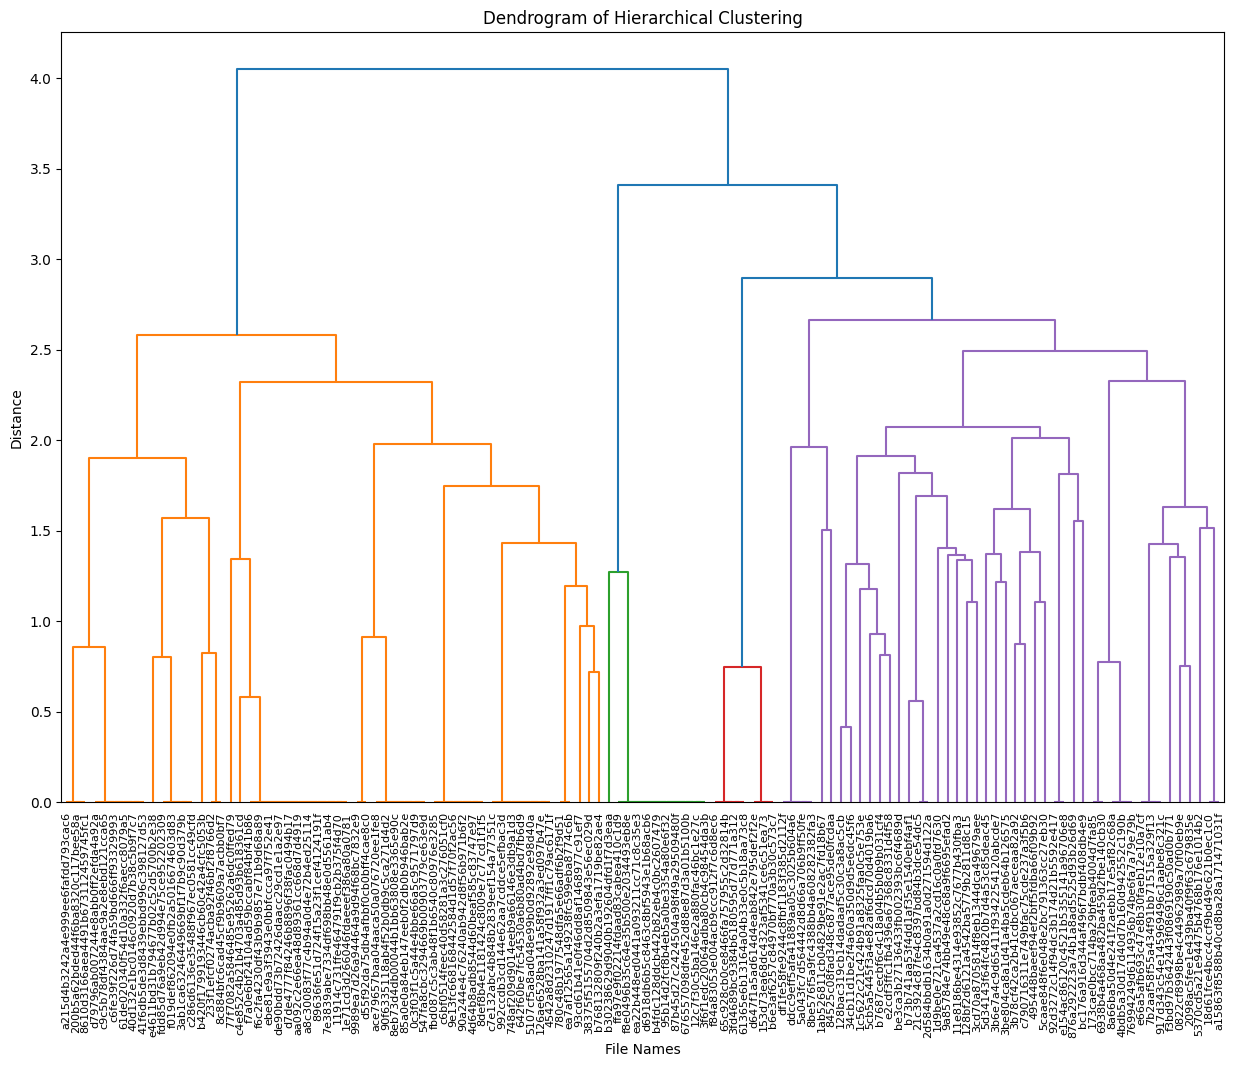

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Performing hierarchical/agglomerative clustering using average linkage
Z = linkage(distance_matrix, method='average')

# Plotting the dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=df['file_name'].values, leaf_rotation=90, leaf_font_size=8)
plt.xlabel('File Names')
plt.ylabel('Distance')
plt.title('Dendrogram of Hierarchical Clustering')
plt.show()

In [36]:
from scipy.cluster.hierarchy import fcluster

# Cutting the dendrogram using a distance threshold
distance_threshold = 3
cluster_labels = fcluster(Z, t=distance_threshold, criterion='distance')

In [37]:
# Printing the number of unique clusters
print("Number of clusters:", len(np.unique(cluster_labels)))

Number of clusters: 3


In [38]:
# Defining the number of clusters
num_clusters = 54

# Assigning cluster labels
df['cluster_labels'] = fcluster(Z, num_clusters, criterion='maxclust')

In [84]:
def parse_process_model(model_string):
    tokens = []
    i = 0
    while i < len(model_string):
        c = model_string[i]
        if c in ["(", ")", ",", "+", "*", "X"]:
            if c == ")" and i+1 < len(model_string) and model_string[i+1] == ",":
                tokens.append("),")
                i += 1
            else:
                tokens.append(c)
        elif c == "-":
            if i+1 < len(model_string) and model_string[i+1] == ">":
                tokens.append("->")
                i += 1
        elif c == " ":
            pass
        elif c == "'":
            start = i + 1
            end = model_string.find("'", start)
            tokens.append(model_string[start:end])
            i = end
        elif c.isalpha():
            start = i
            while i < len(model_string) and (model_string[i].isalnum() or model_string[i] == "_"):
                i += 1
            tokens.append(model_string[start:i])
            i -= 1
        i += 1
    return tokens

def translate_recursive(tokens, idx=0):
    description = ""
    while idx < len(tokens):
        token = tokens[idx]

        if token == "->":
            description += " followed by "
        elif token == "+":
            description += " in parallel with "
        elif token == ",":
            description += ", "
        elif token == "tau":
            description += "a silent action"
        elif token == "X":
            inner_description, idx = translate_recursive(tokens, idx + 2)
            description += f"an exclusive choice between {inner_description}"
        elif token == "*":
            loop_start_idx = idx + 2
            inner_description, loop_end_idx = translate_recursive(tokens, loop_start_idx)
            loop_description = f"a loop between the actions {inner_description}, meaning that these actions can be repeated multiple times in sequence"
            description += loop_description
            idx = loop_end_idx
        elif token == "(":
            inner_description, idx = translate_recursive(tokens, idx + 1)
            description += inner_description
        elif token == ")":
            return description, idx
        elif token == "),":
            description += " and "
        else:
            description += f"the action '{token}'"

        idx += 1

    return description, idx

def remove_consecutive_substrings(s, sub):
    while sub + sub in s:
        s = s.replace(sub + sub, sub)
    return s

def translate_process_model(model_string):
    # Combine parsing and translation functions
    tokens = parse_process_model(model_string)
    description, _ = translate_recursive(tokens)

    # Remove consecutive occurrences of the phrase
    repeating_phrase = ", meaning that these actions can be repeated multiple times in sequence"
    description = remove_consecutive_substrings(description, repeating_phrase)

    return description

# Example usage
model_string = "->( X( tau, X( 'prompt', 'gpt3-call' ) ), X( tau, +( *( 'user', tau ) ), X( tau, *( 'empty-call', 'modify-gpt3' ) ) ) )"
print(translate_process_model(model_string))

model_string1 = "->( X( tau, X( 'prompt', ->( 'gpt3-call', X( tau, 'modify-gpt3' ) ) ) ), X( tau, *( 'user', *( 'empty-call', tau ) ) ) )"
print(translate_process_model(model_string1))

 followed by an exclusive choice between a silent action, an exclusive choice between the action 'prompt', the action 'gpt3-call' and an exclusive choice between a silent action,  in parallel with a loop between the actions the action 'user', a silent action, meaning that these actions can be repeated multiple times in sequence and an exclusive choice between a silent action, a loop between the actions the action 'empty-call', the action 'modify-gpt3', meaning that these actions can be repeated multiple times in sequence
 followed by an exclusive choice between a silent action, an exclusive choice between the action 'prompt',  followed by the action 'gpt3-call', an exclusive choice between a silent action, the action 'modify-gpt3' and an exclusive choice between a silent action, a loop between the actions the action 'user', a loop between the actions the action 'empty-call', a silent action, meaning that these actions can be repeated multiple times in sequence


In [46]:
def apply_translation(row):
    # Convert the ProcessTree object to its string representation before translation
    return translate_process_model(str(row['process_model']))

In [47]:
df['translated_description'] = df.apply(apply_translation, axis=1)

In [48]:
df.to_csv("sequential_clustering.csv")

### Alpha Mining

In [49]:
# Importing the Alpha Miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

In [50]:
# Applying the Alpha Miner to the 'event_log' column and storing the resulting Petri net, initial marking, and final marking in new columns
df1 = df
df1[['petri_net', 'initial_marking', 'final_marking']] = df1['event_log'].apply(lambda log: alpha_miner.apply(log)).apply(pd.Series)

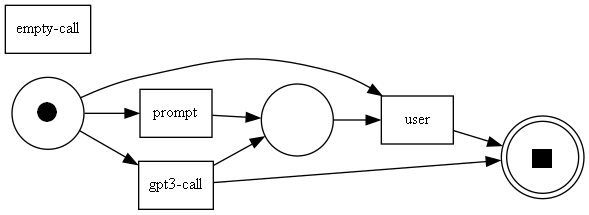

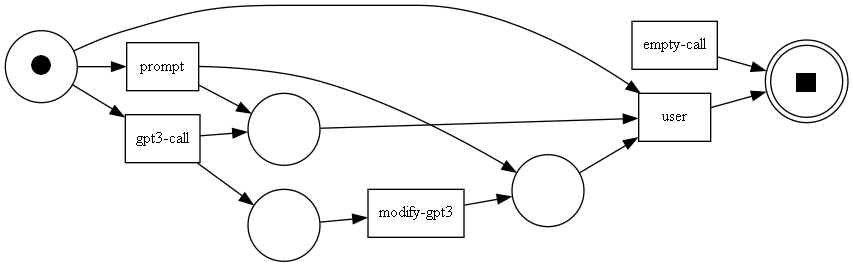

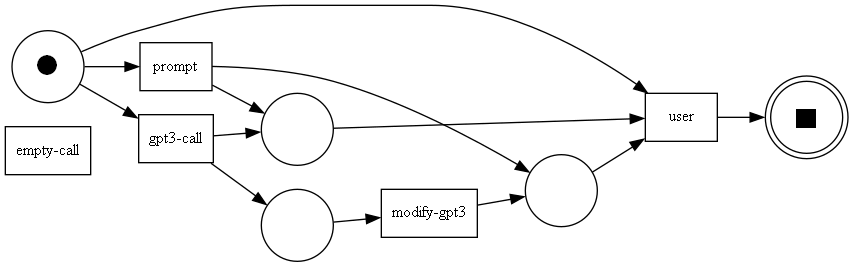

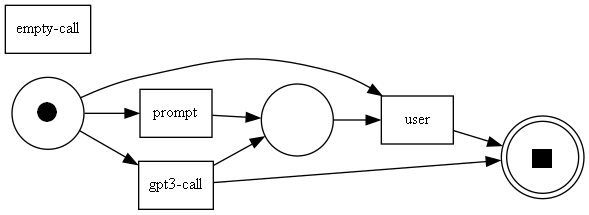

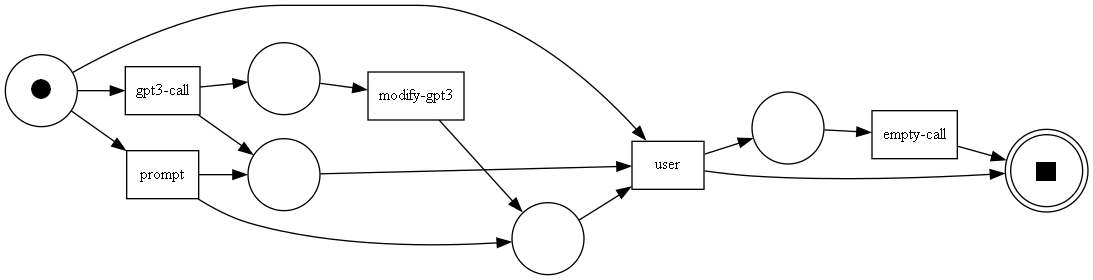

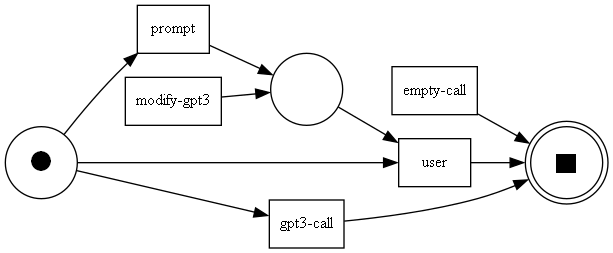

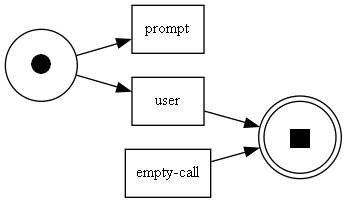

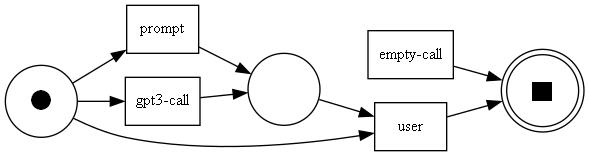

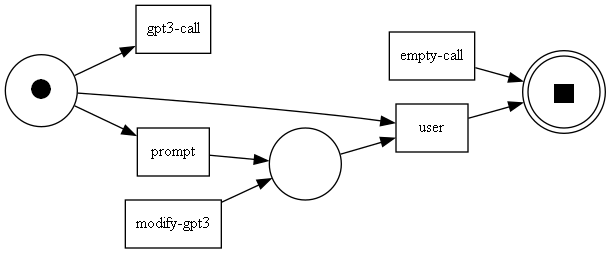

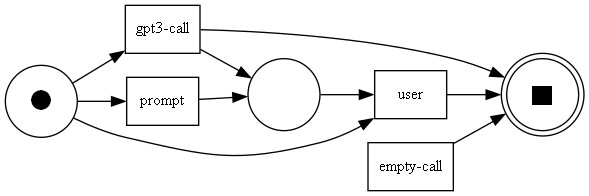

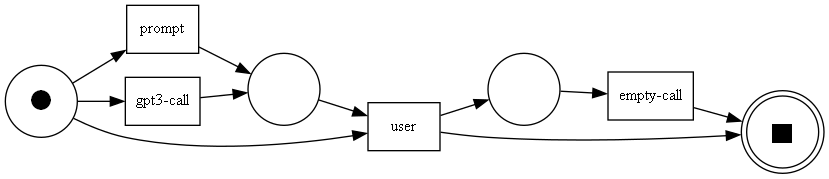

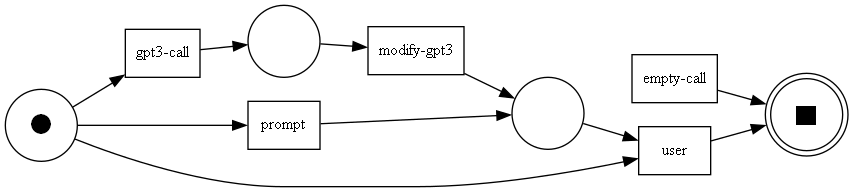

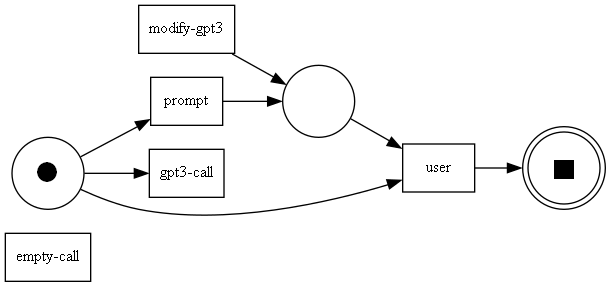

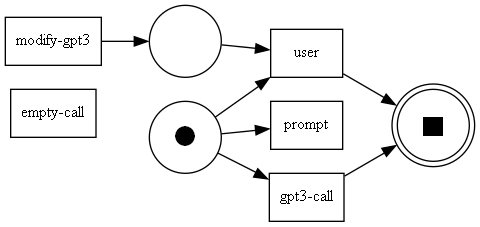

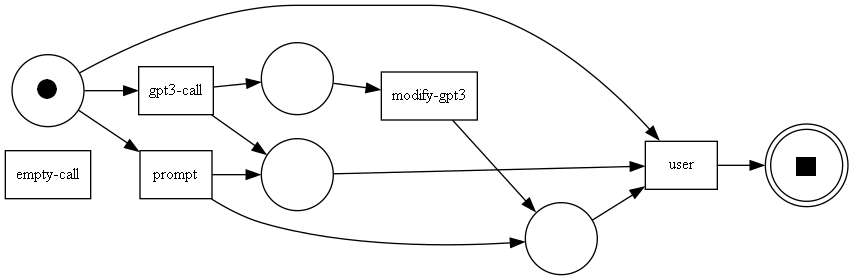

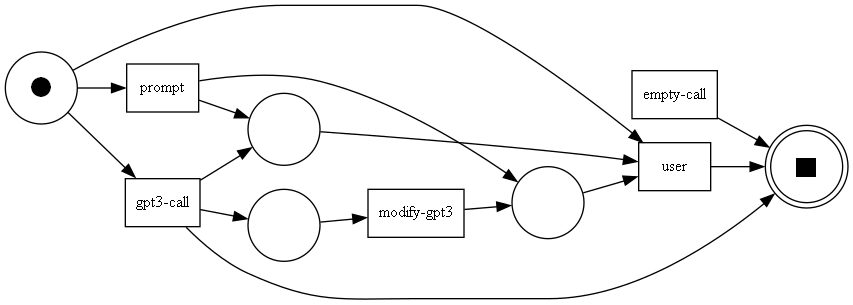

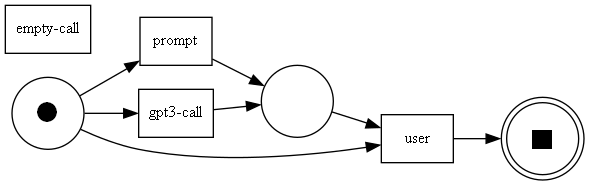

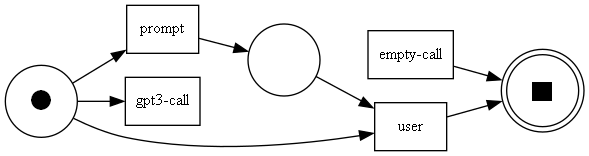

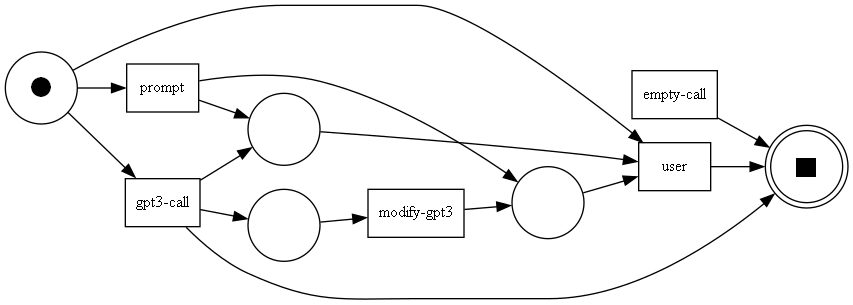

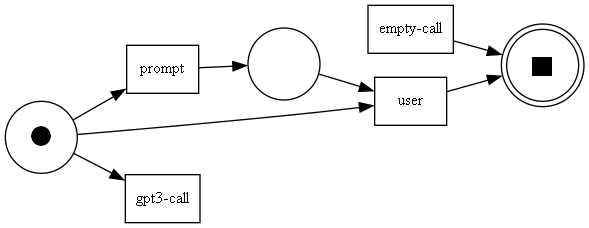

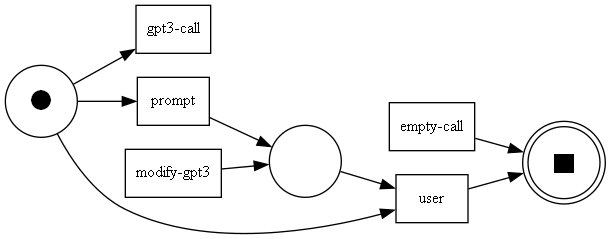

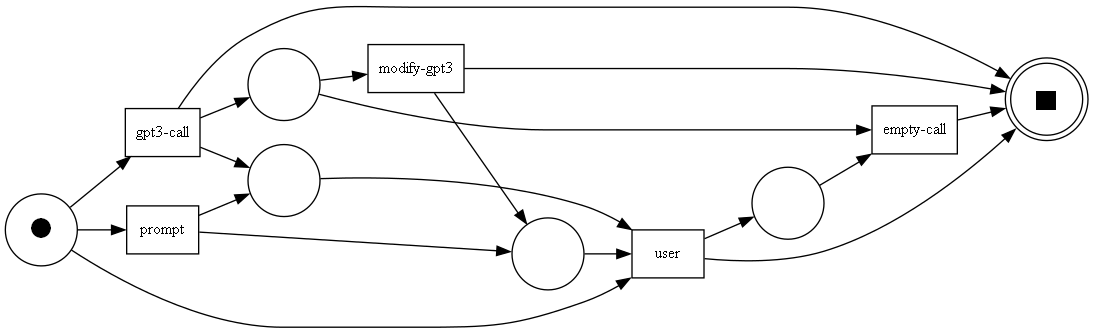

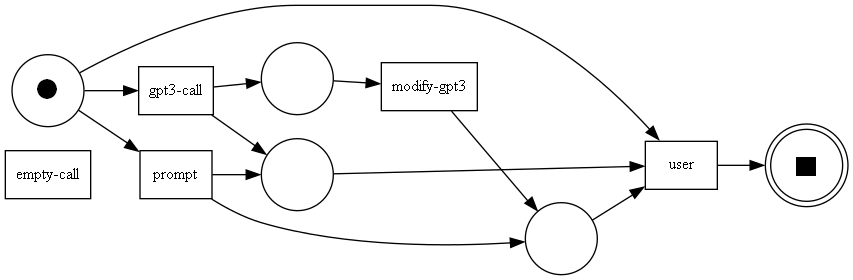

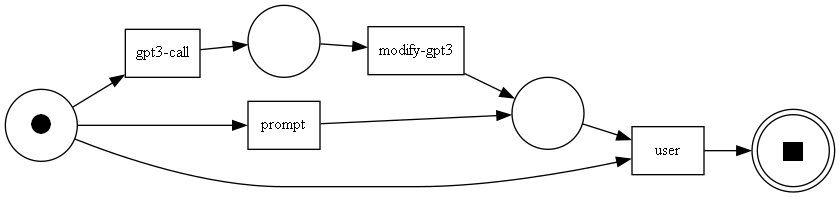

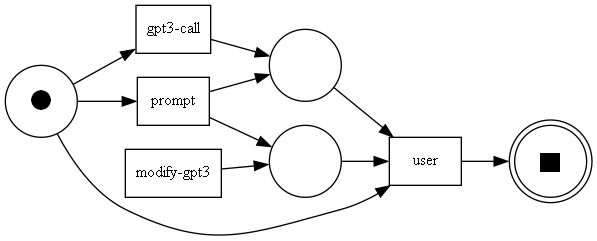

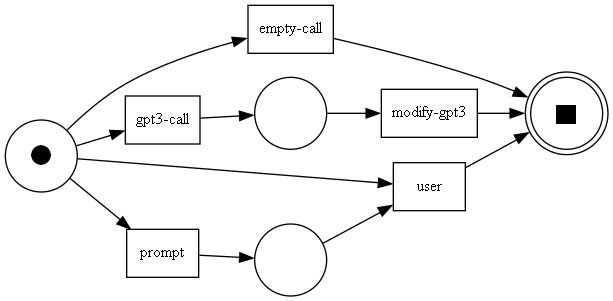

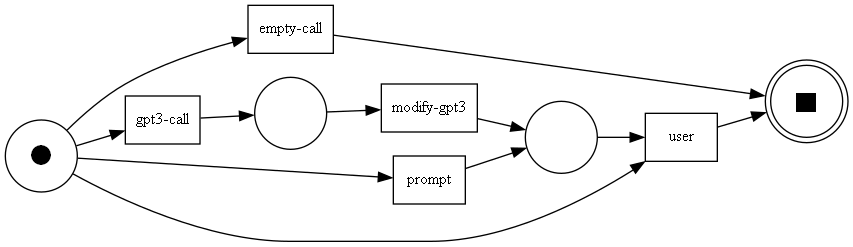

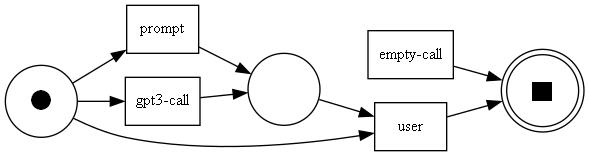

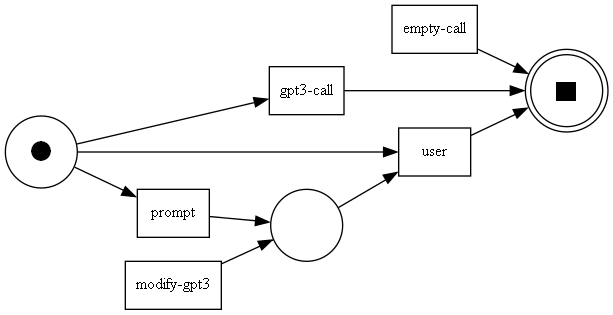

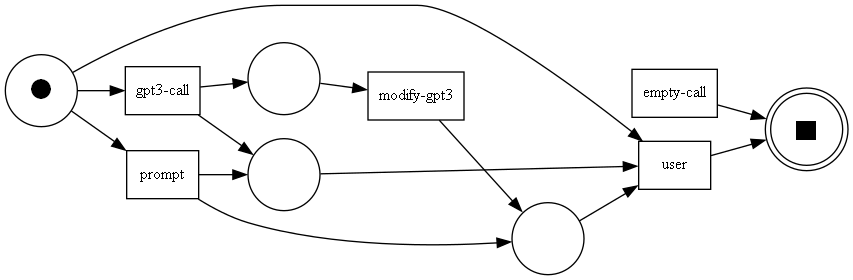

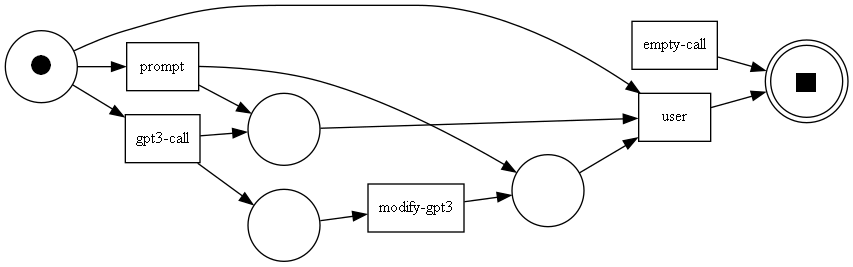

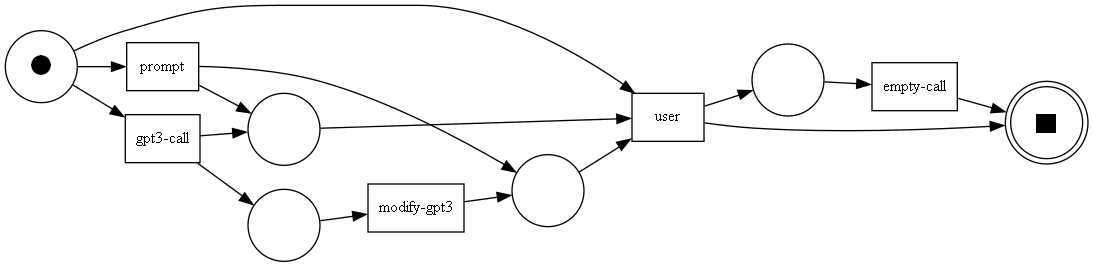

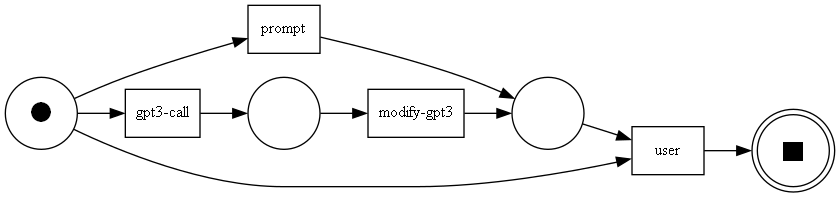

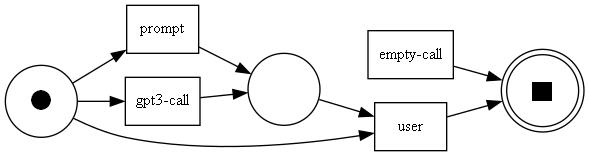

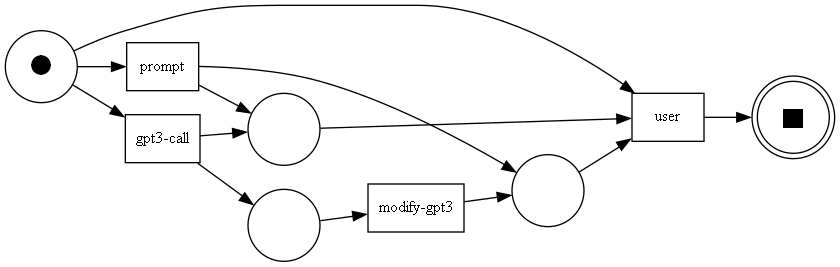

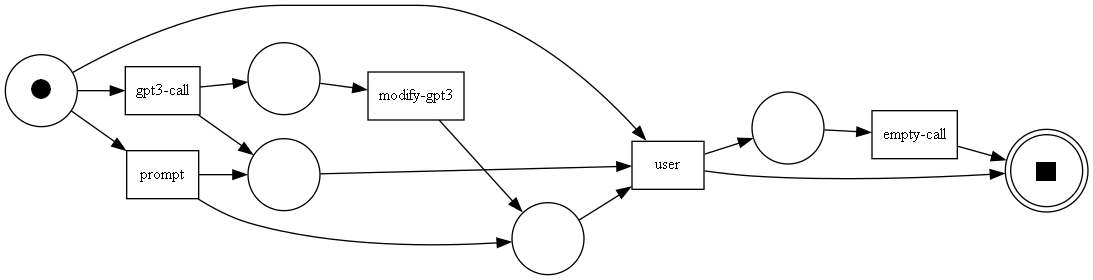

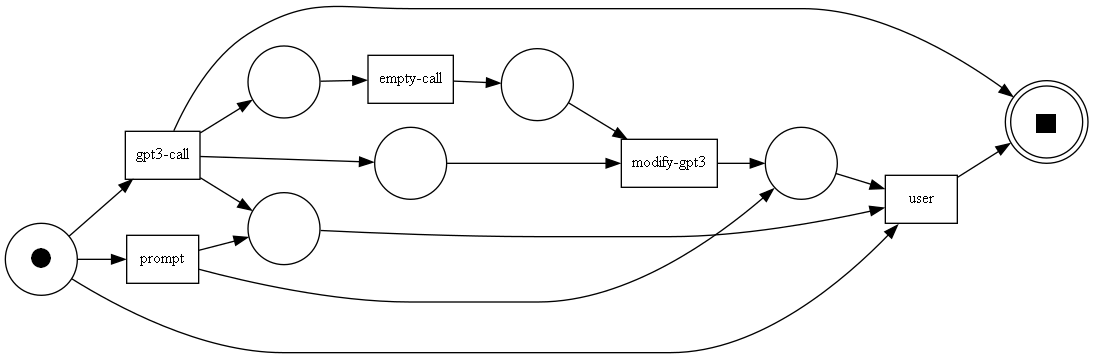

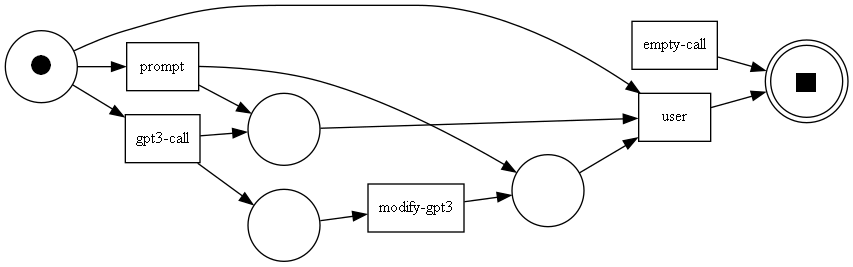

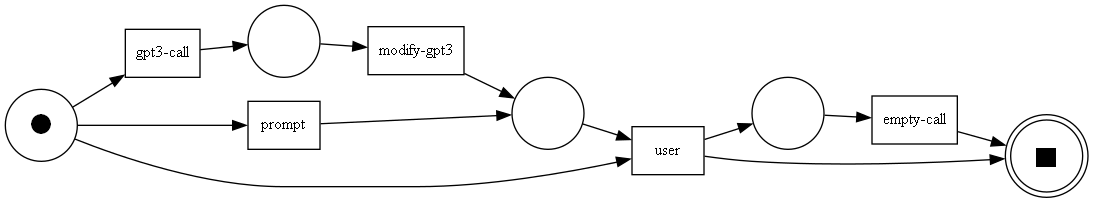

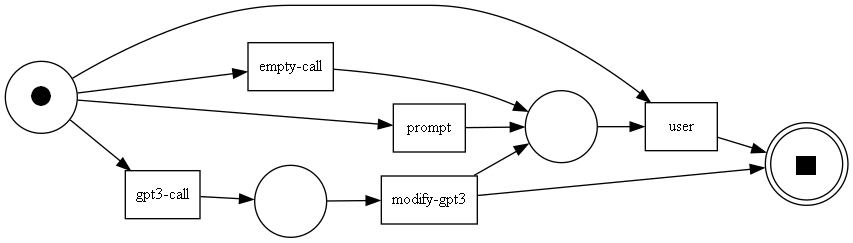

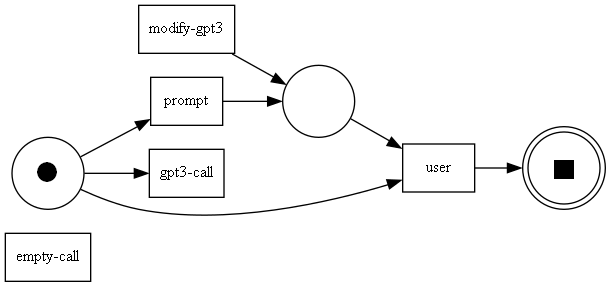

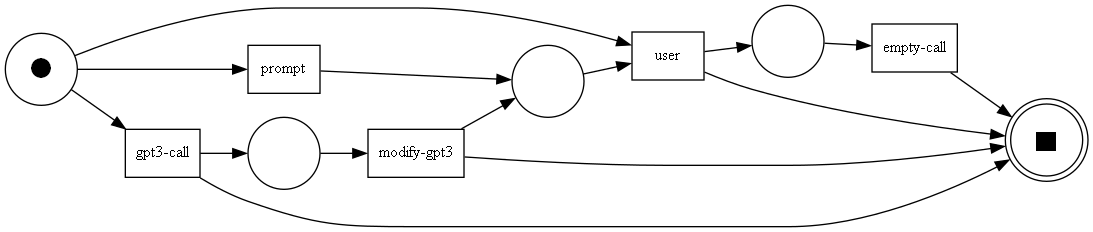

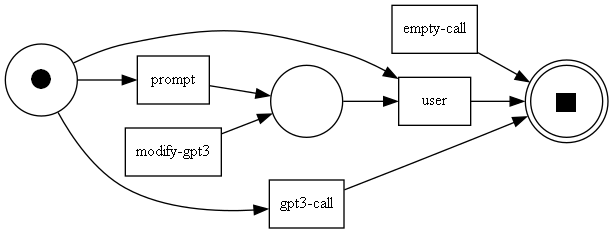

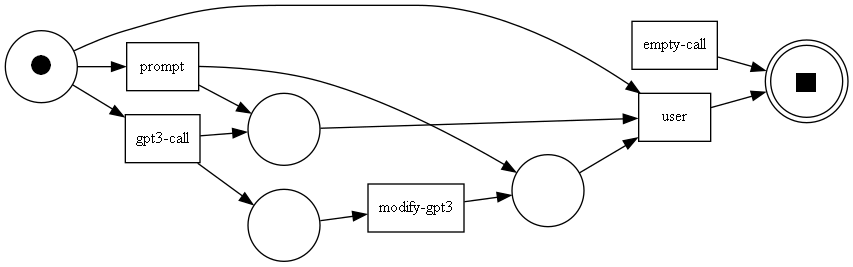

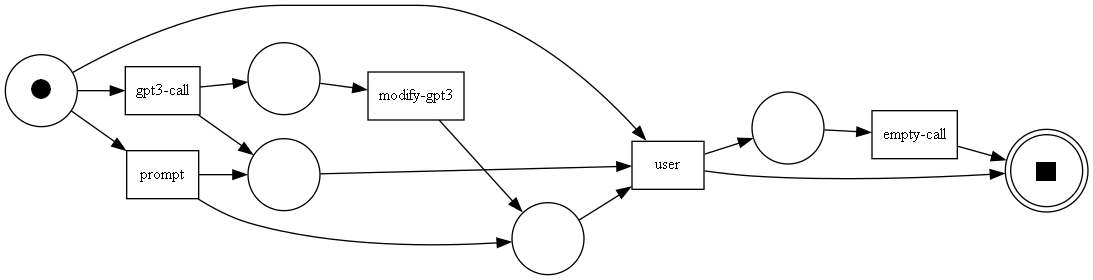

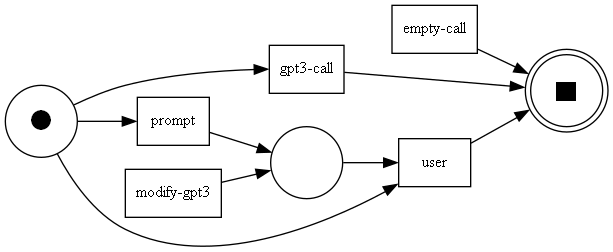

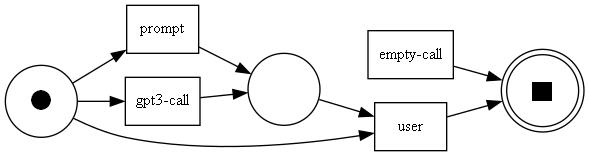

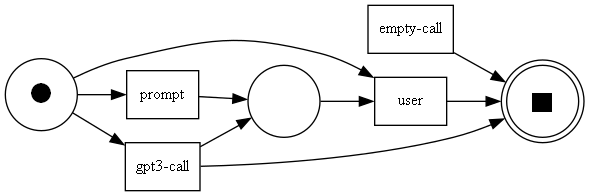

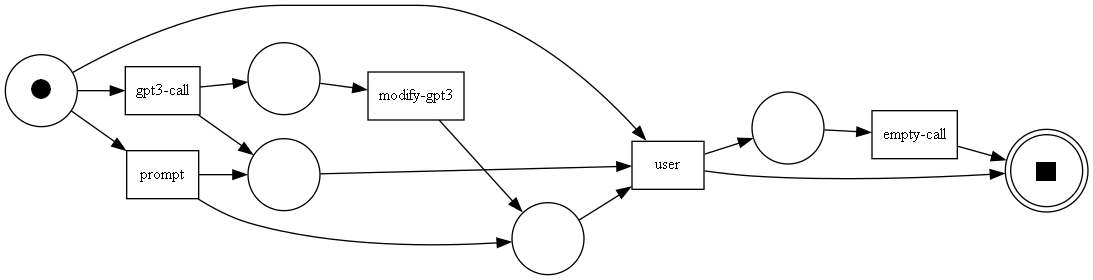

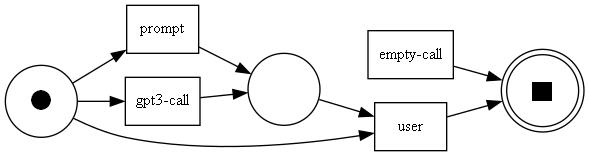

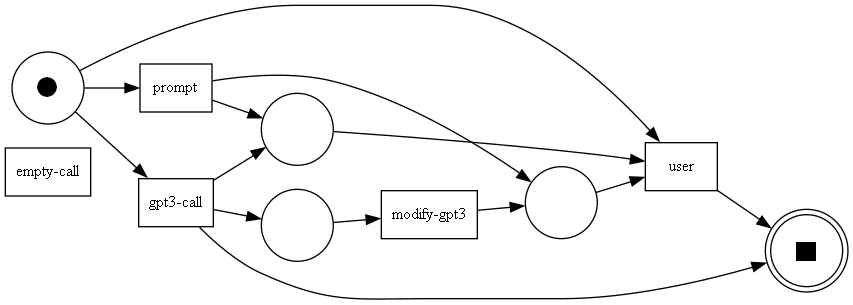

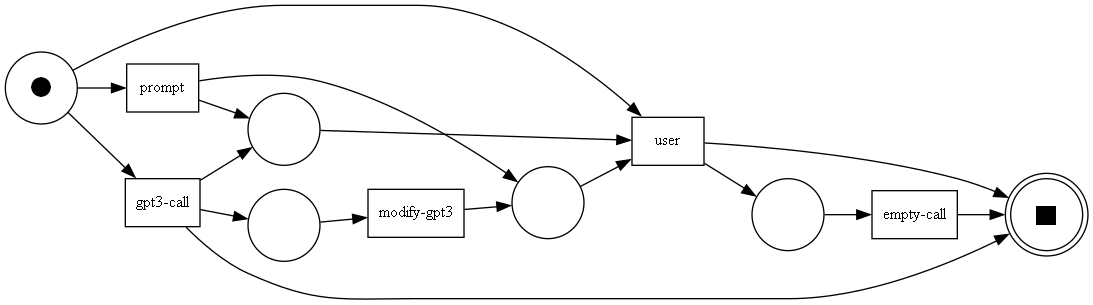

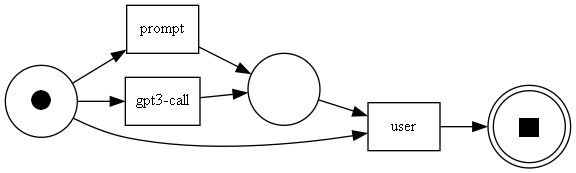

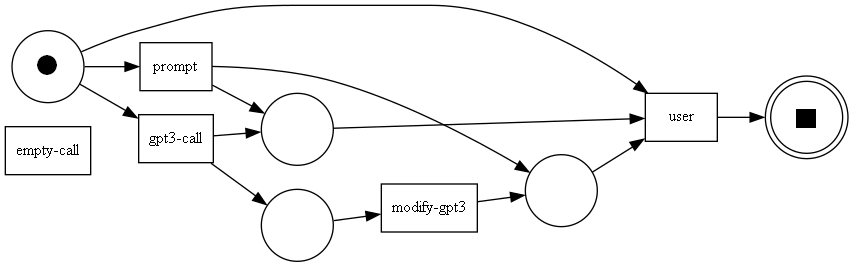

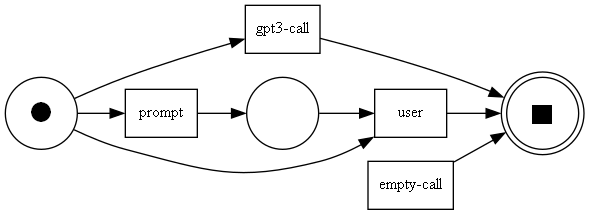

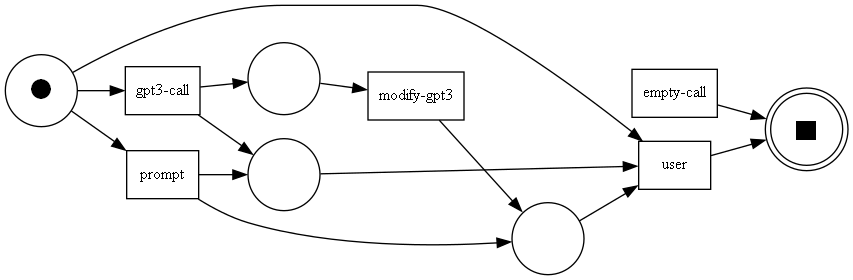

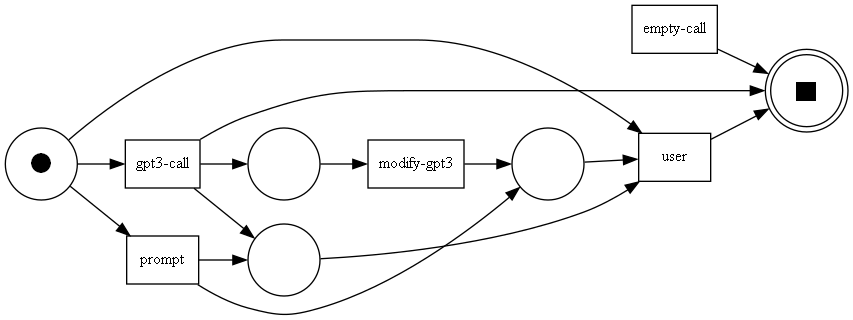

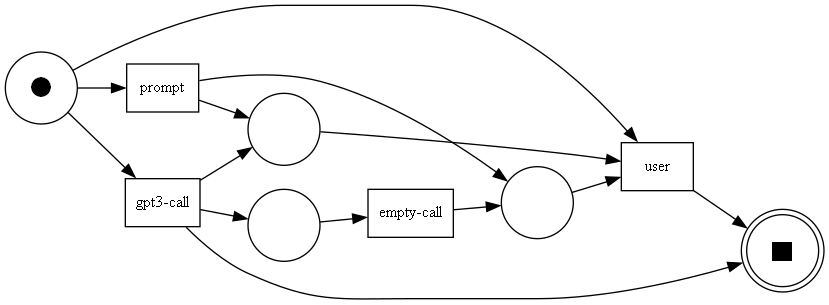

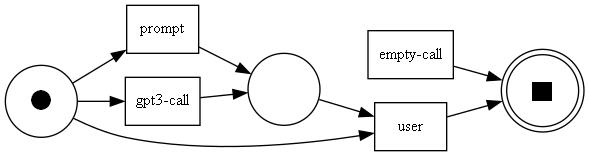

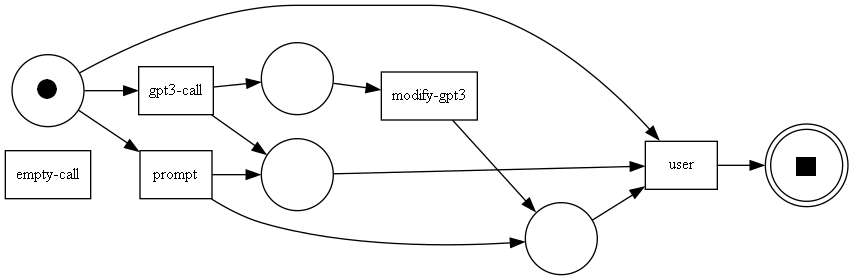

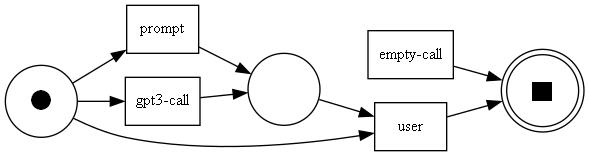

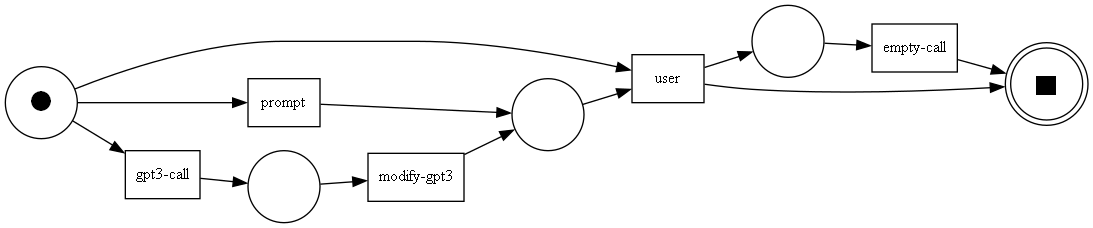

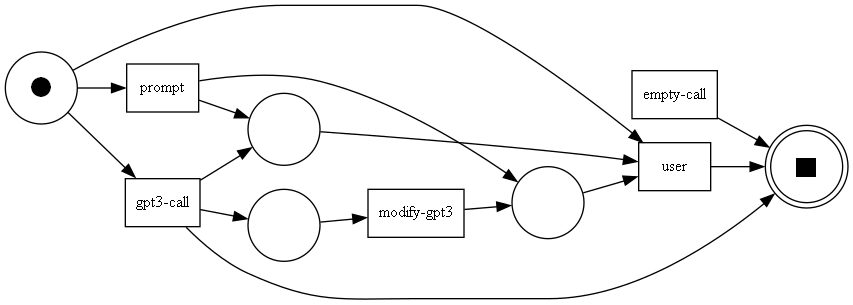

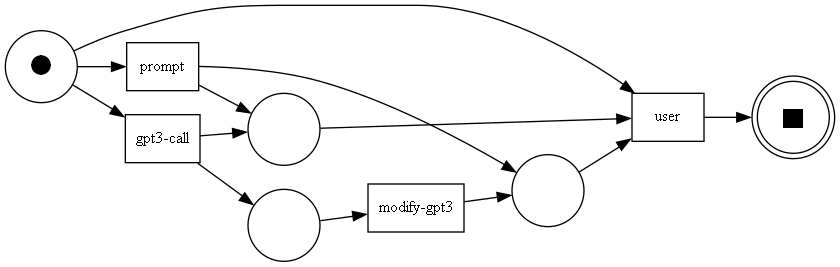

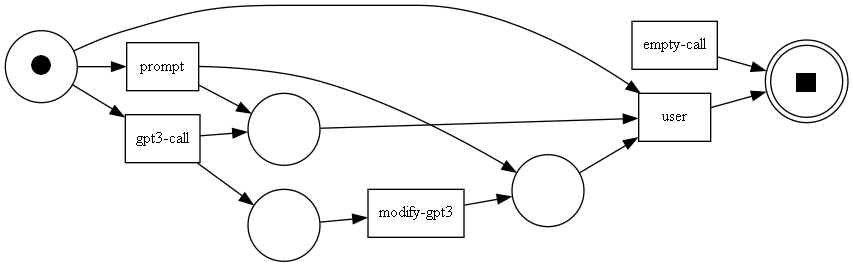

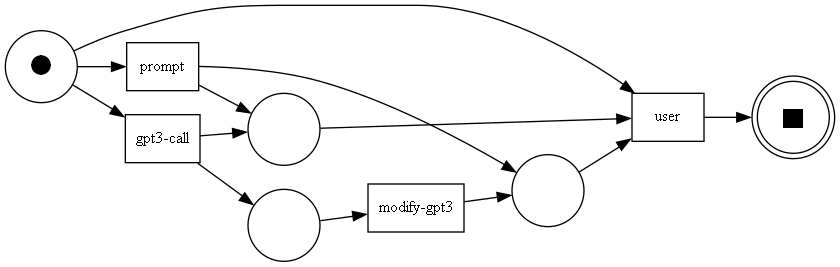

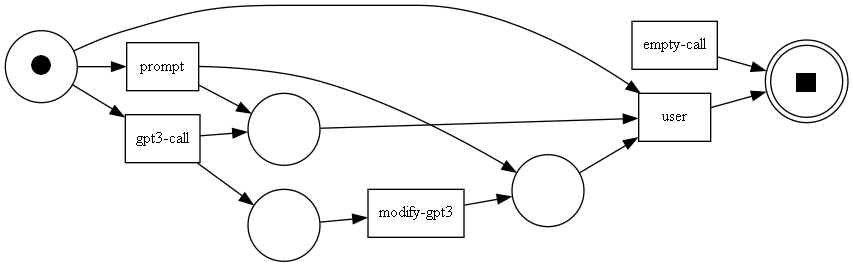

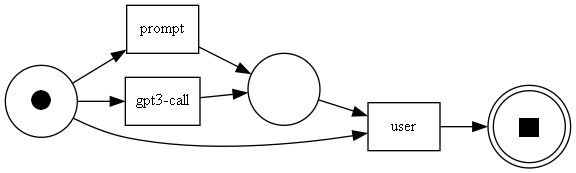

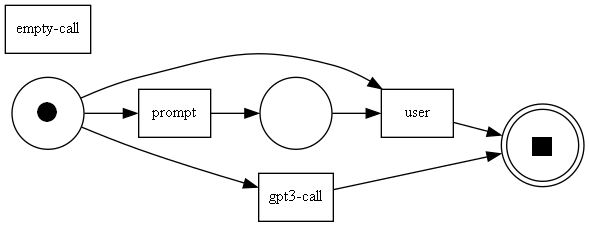

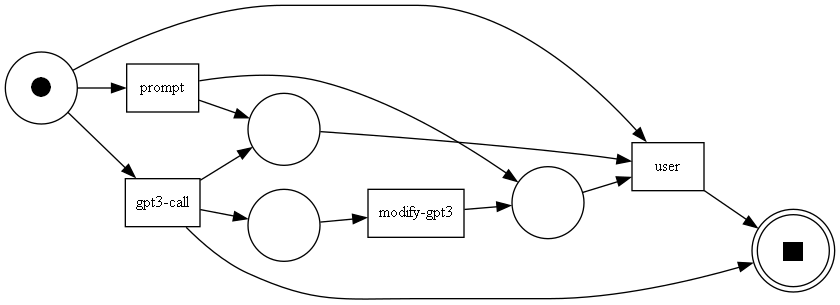

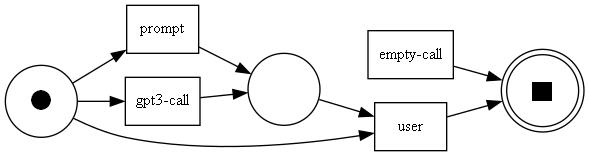

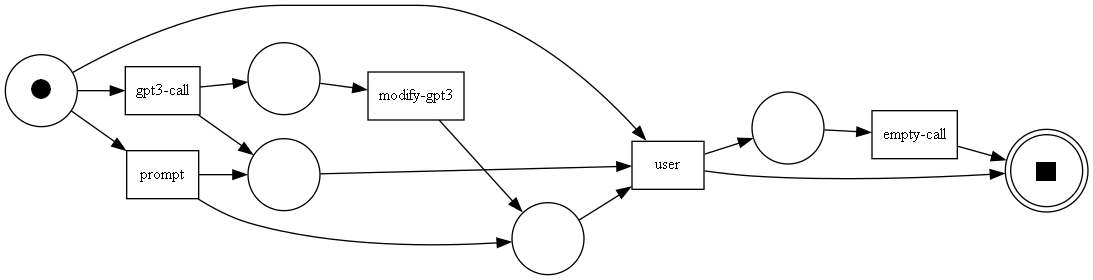

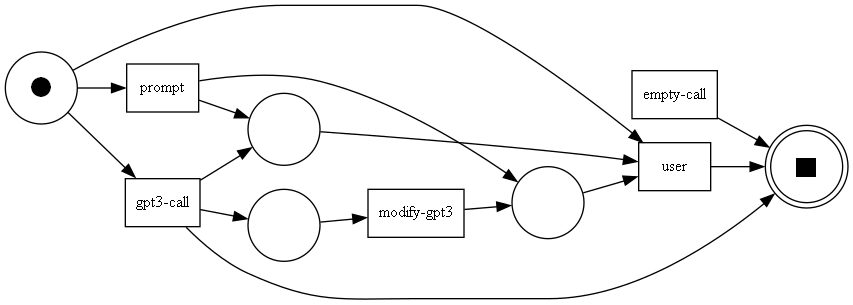

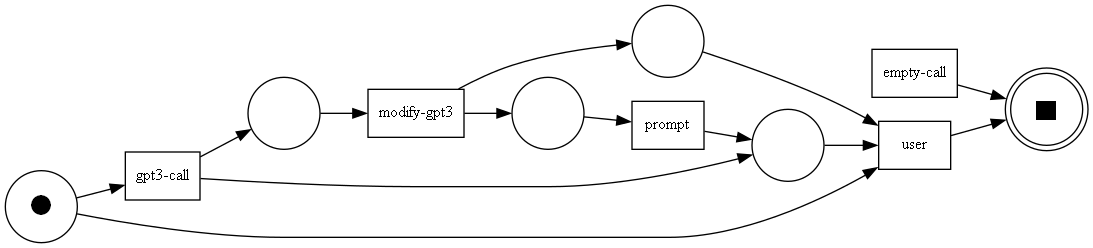

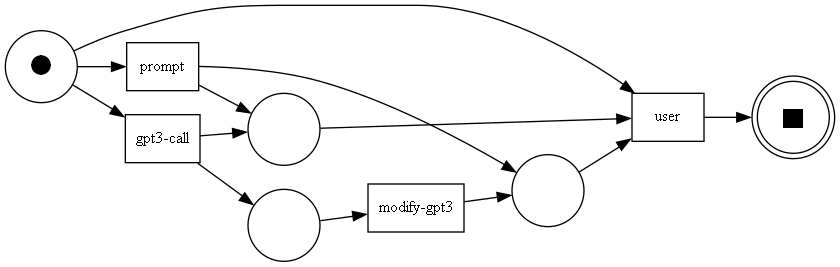

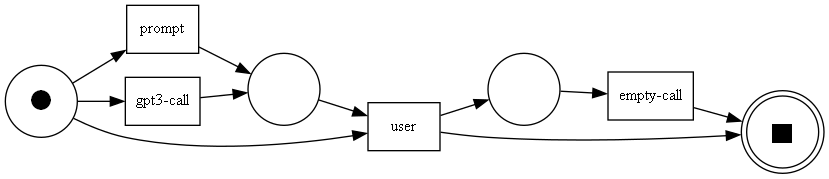

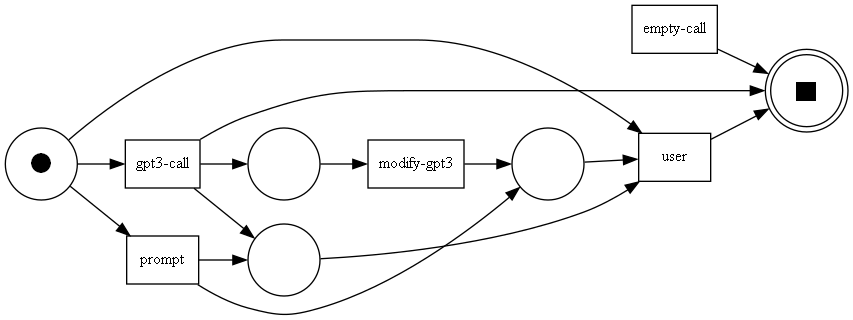

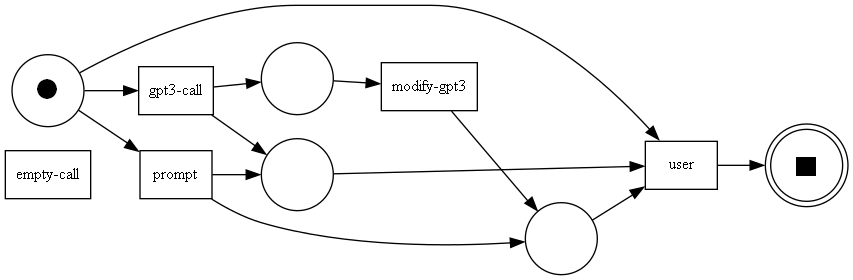

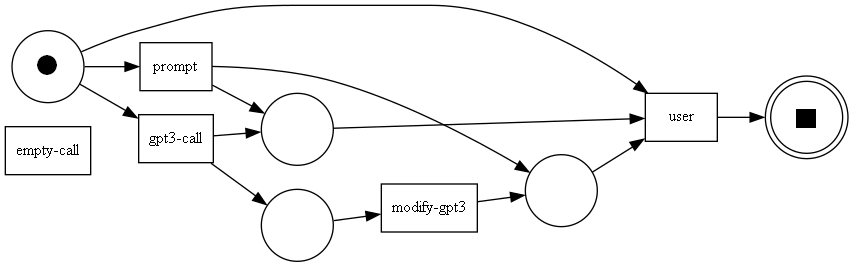

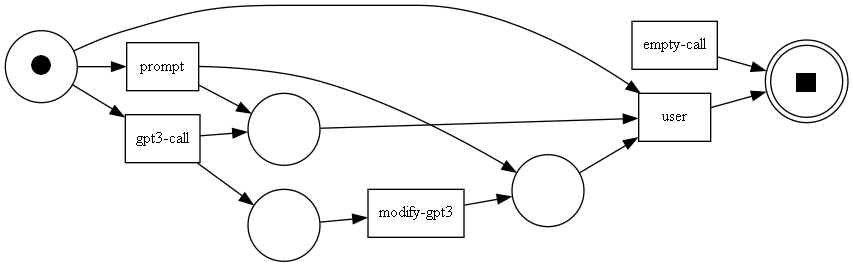

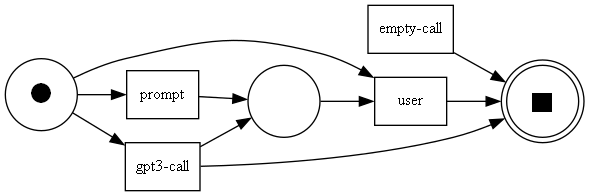

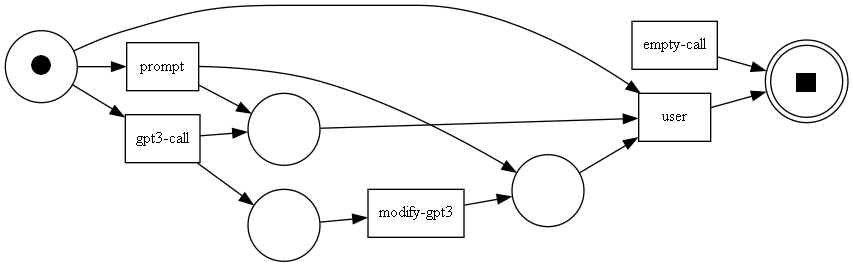

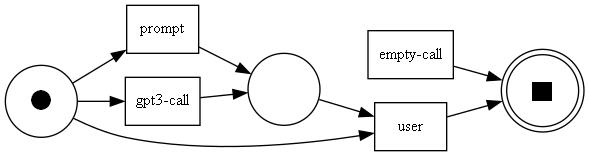

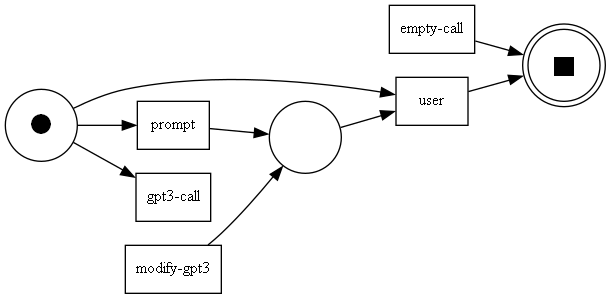

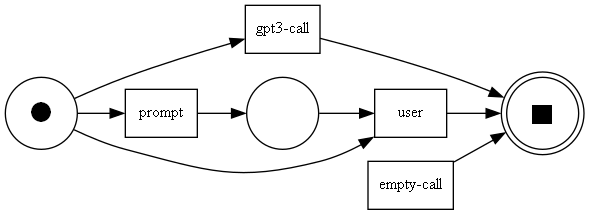

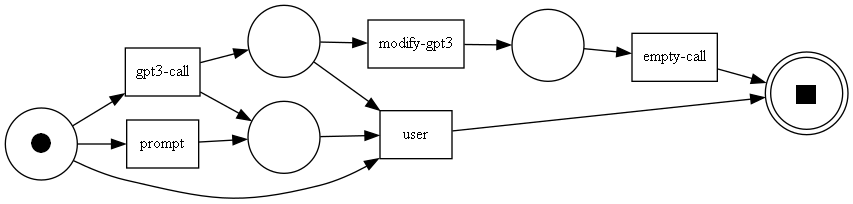

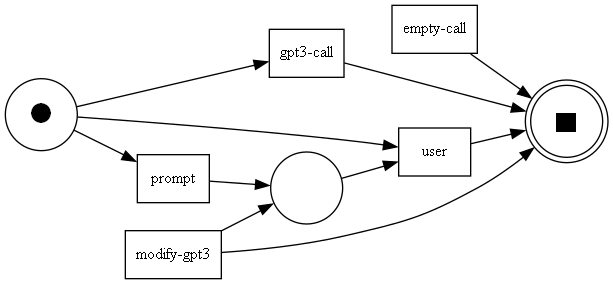

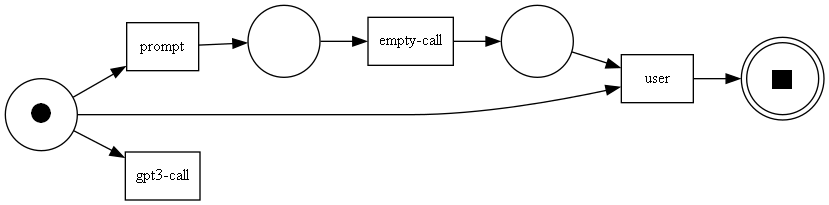

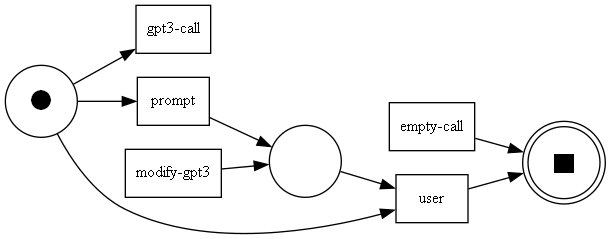

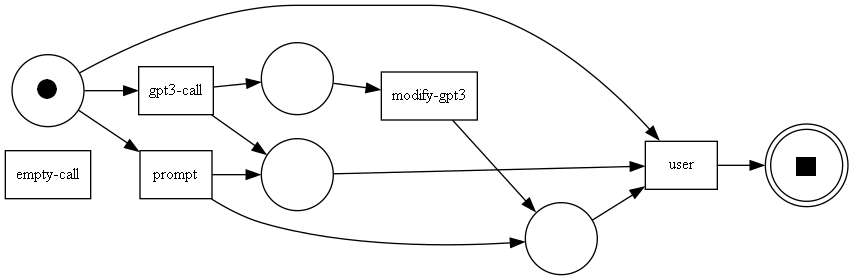

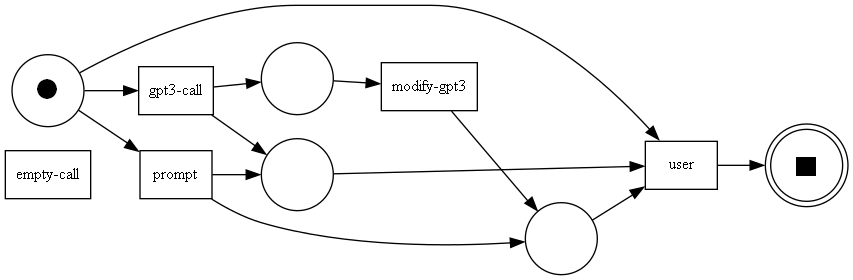

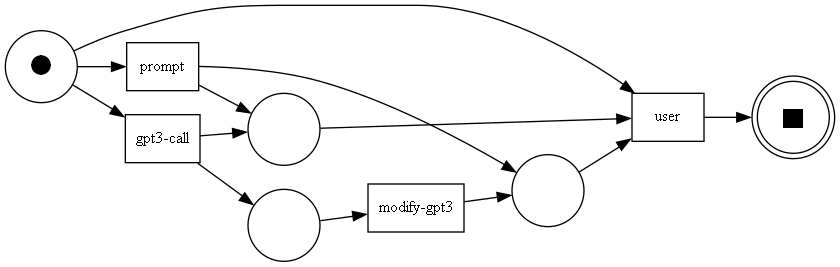

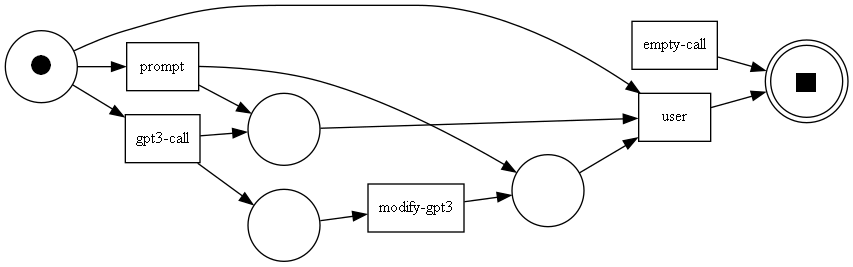

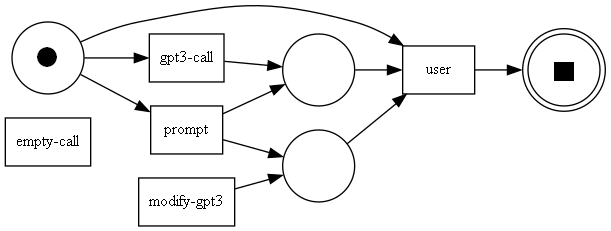

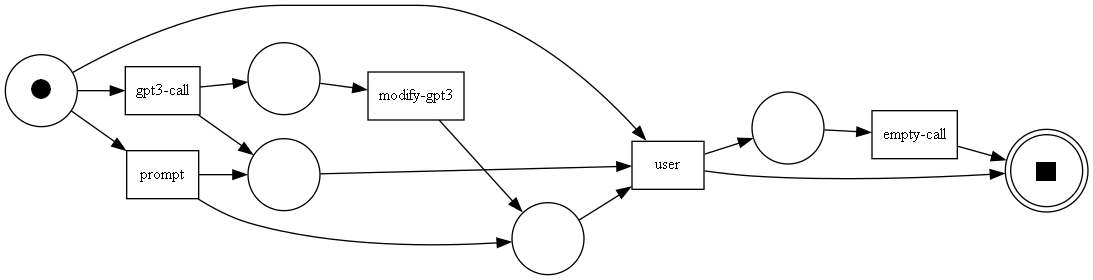

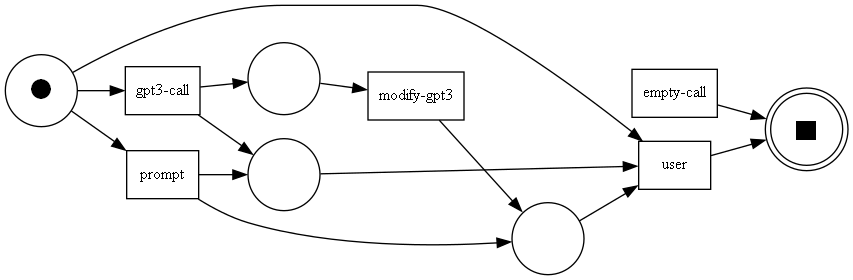

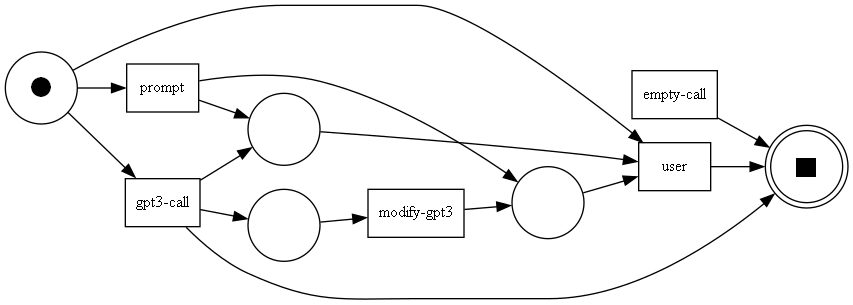

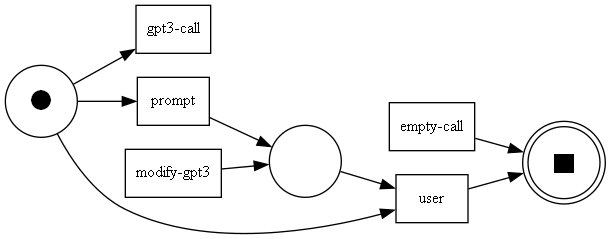

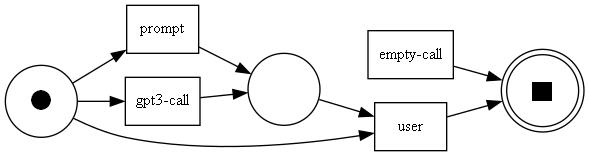

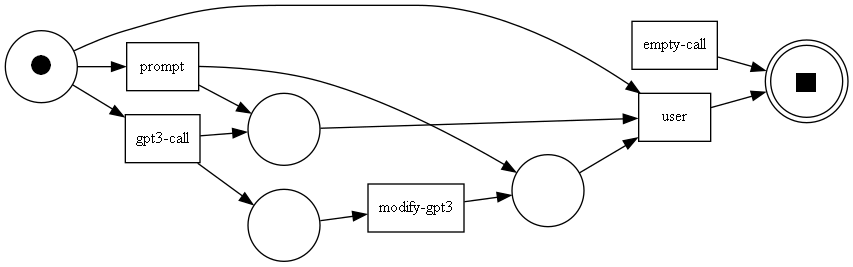

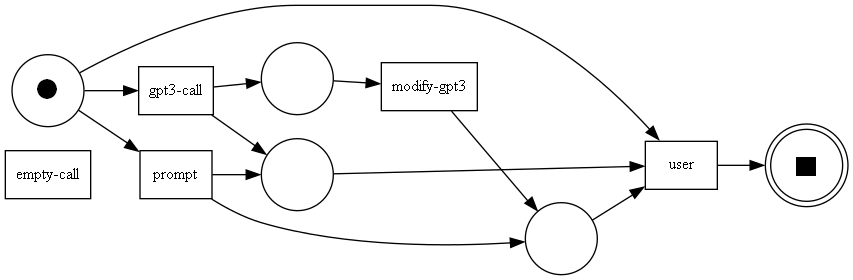

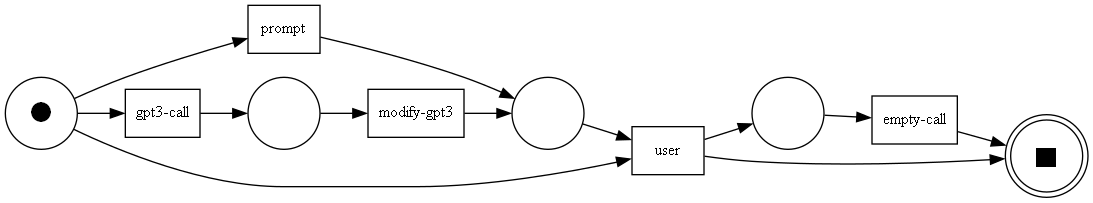

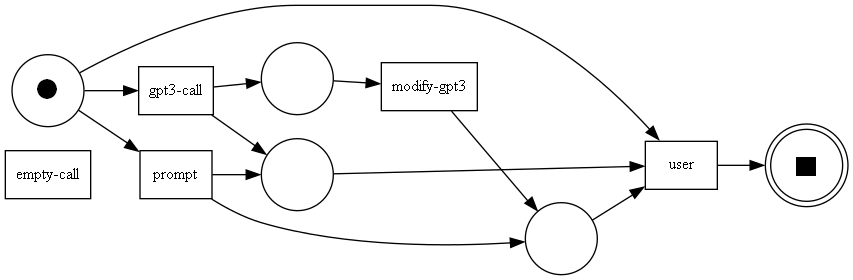

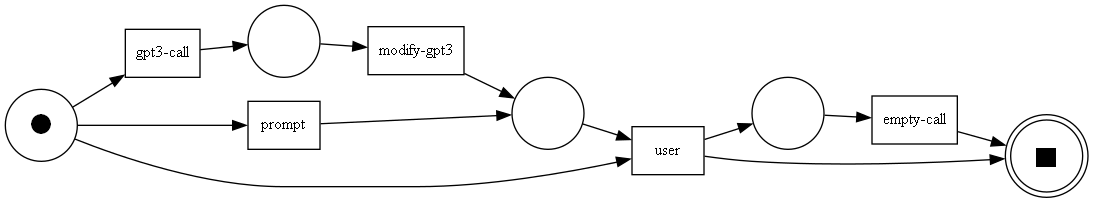

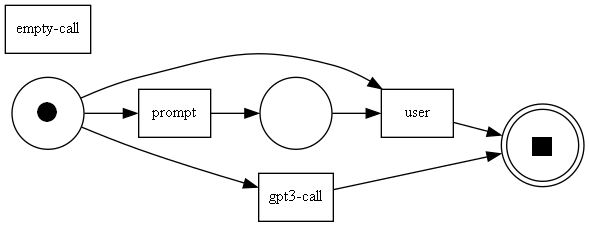

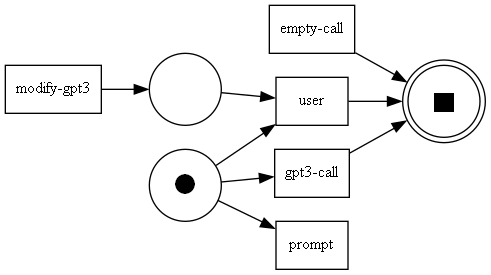

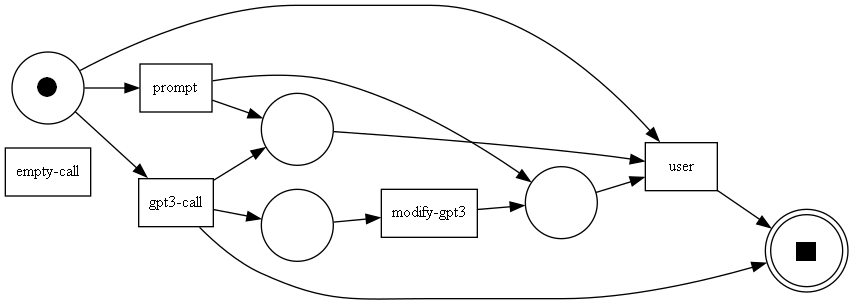

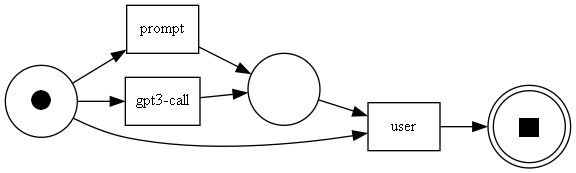

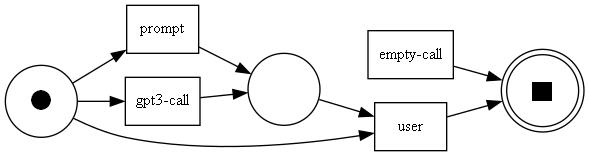

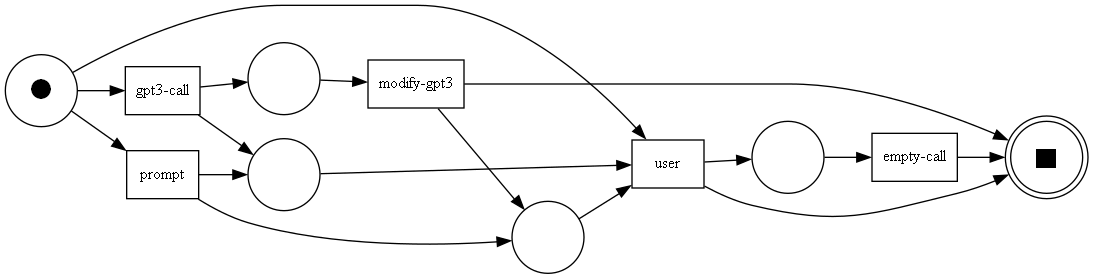

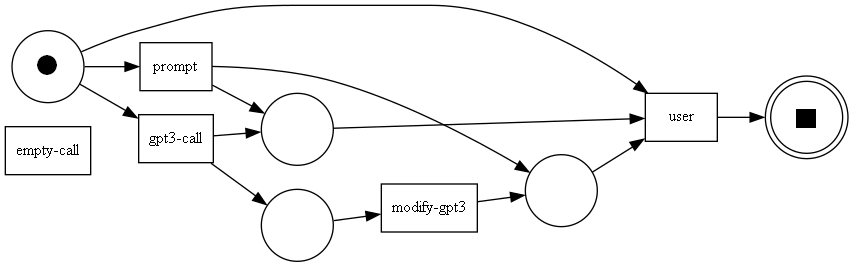

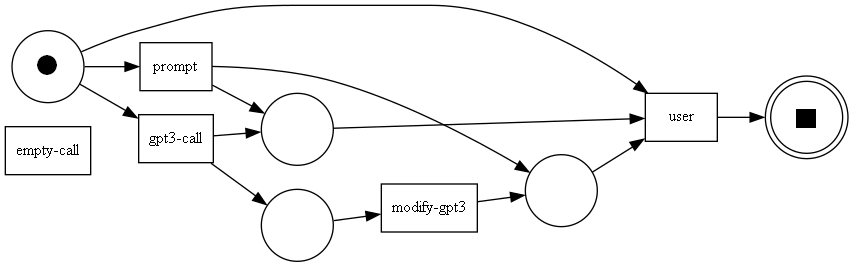

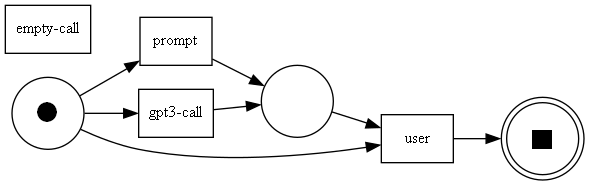

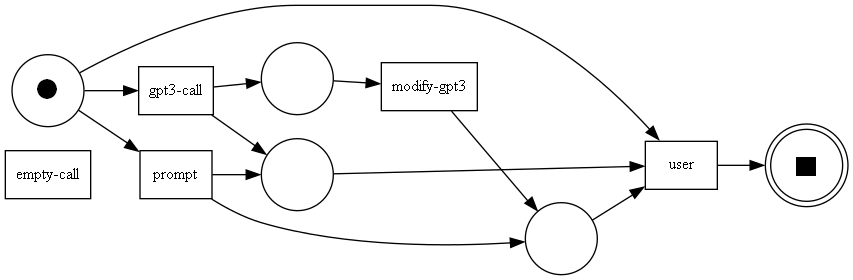

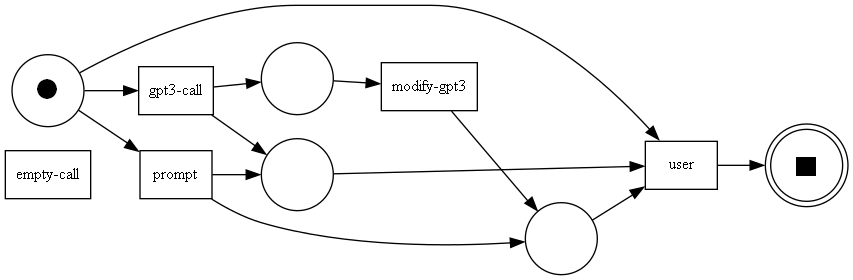

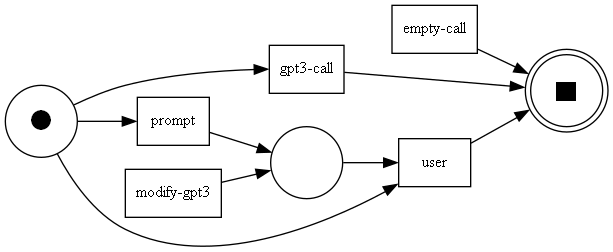

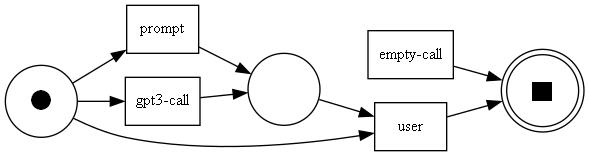

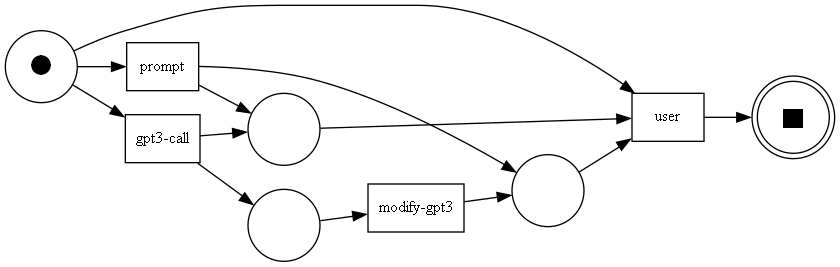

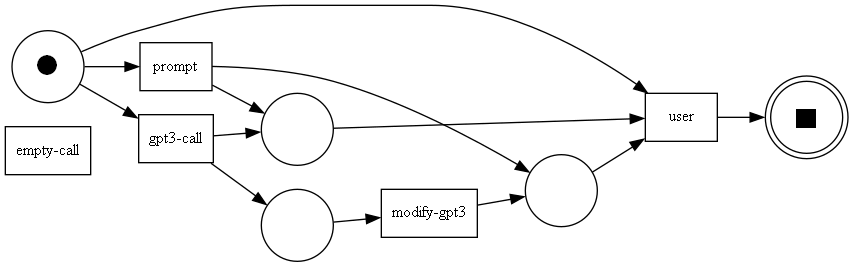

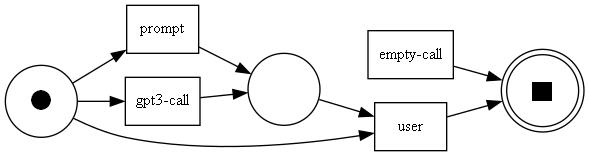

In [51]:
# Visualising the Petri nets
from pm4py.visualization.petri_net import visualizer as pn_visualizer

for index, row in df.iterrows():
    gviz = pn_visualizer.apply(row['petri_net'], row['initial_marking'], row['final_marking'])
    pn_visualizer.view(gviz)

In [52]:
# Calculating the Jaccard similarity between two Petri nets
def jaccard_similarity(petri_net1, petri_net2):
    arcs1 = {(arc.source.name, arc.target.name) for arc in petri_net1.arcs}
    arcs2 = {(arc.source.name, arc.target.name) for arc in petri_net2.arcs}

    intersection = len(arcs1.intersection(arcs2))
    union = len(arcs1.union(arcs2))

    return intersection / union

In [53]:
# Calculating the Jaccard similarity matrix for the Petri nets
num_rows = len(df)
similarity_matrix = np.zeros((num_rows, num_rows))

for i in range(num_rows):
    for j in range(num_rows):
        similarity_matrix[i, j] = jaccard_similarity(df['petri_net'].iloc[i], df['petri_net'].iloc[j])

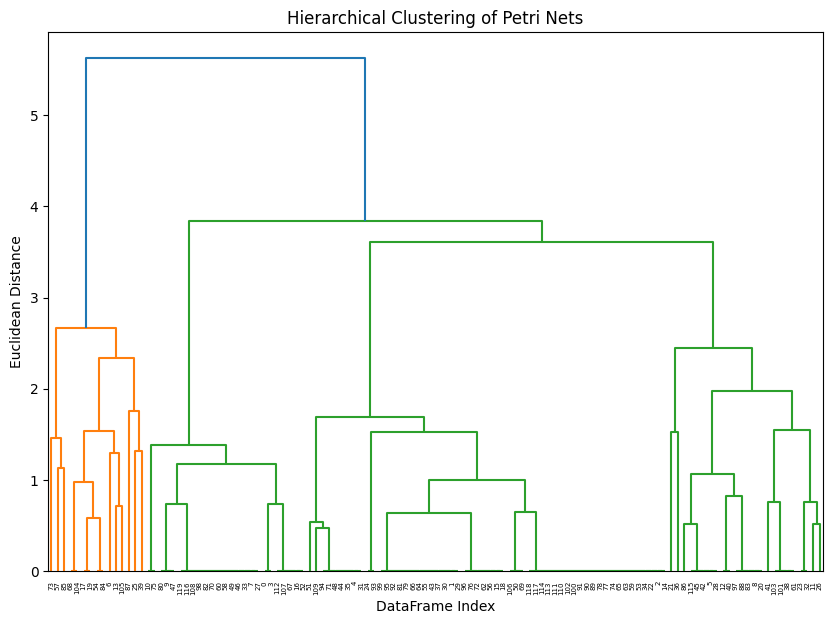

In [54]:
# Performing hierarchical clustering using the Jaccard similarity matrix
from scipy.cluster.hierarchy import linkage, dendrogram

clustering = linkage(similarity_matrix, method='complete', metric='euclidean')

plt.figure(figsize=(10, 7))
dendrogram(clustering)
plt.xlabel('DataFrame Index')
plt.ylabel('Euclidean Distance')
plt.title('Hierarchical Clustering of Petri Nets')
plt.show()

In [55]:
from scipy.cluster.hierarchy import fcluster

threshold = 2.5  # Setting an appropriate threshold based on the dendrogram
clusters = fcluster(clustering, threshold, criterion='distance')
df1['alpha_cluster'] = clusters

In [56]:
df1.head()

file_name  \
0  0822cf8998be4c44962989a70f00eb9e   
1  0c3f03f1c5a44e4bbe66a5c9571797d9   
2  11914c731ffe464791f9cb2b375f4d70   
3  11e8186be4314e93852c7677b430fba3   
4  126ae6528ba141a58f932a3ed097b47e   

                                                text  \
0  Humans once wielded formidable magical power. ...   
1  An alien has kidnapped Matt Damon, not knowing...   
2  Is Listening to a Book Just as Good as Reading...   
3  Your entire life, you've been told you're deat...   
4  All of the "#1 Dad" mugs in the world changed ...   

                                    sentence_metrics  \
0  {'Total number of sentences': 25, 'Number of s...   
1  {'Total number of sentences': 18, 'Number of s...   
2  {'Total number of sentences': 15, 'Number of s...   
3  {'Total number of sentences': 36, 'Number of s...   
4  {'Total number of sentences': 21, 'Number of s...   

                                         api_metrics  \
0  {'Total number of GPT-3 calls made': 24, 'Numb...   
1  {'Total number of GPT-3 calls made': 10, 'Numb...   
2  {'Total number of GPT-3 calls made': 4, 'Numbe...   
3  {'Total number of GPT-3 calls made': 30, 'Numb...   
4  {'Total number of GPT-3 calls made': 6, 'Numbe...   

                                    action_sequences  \
0  [(3, [prompt, user]), (4, [user, empty-call, u...   
1  [(1, [prompt, user]), (2, [gpt3-call, user]), ...   
2  [(7, [prompt, user]), (8, [gpt3-call, modify-g...   
3  [(4, [prompt, user]), (5, [user]), (6, [gpt3-c...   
4  [(1, [prompt, user]), (2, [user]), (3, [gpt3-c...   

                                sentence_action_dict  \
0  {3: ['prompt', 'user'], 4: ['user', 'empty-cal...   
1  {1: ['prompt', 'user'], 2: ['gpt3-call', 'user...   
2  {7: ['prompt', 'user'], 8: ['gpt3-call', 'modi...   
3  {4: ['prompt', 'user'], 5: ['user'], 6: ['gpt3...   
4  {1: ['prompt', 'user'], 2: ['user'], 3: ['gpt3...   

                                           event_log  \
0  [[[concept:name], [concept:name]], [[concept:n...   
1  [[[concept:name], [concept:name]], [[concept:n...   
2  [[[concept:name], [concept:name]], [[concept:n...   
3  [[[concept:name], [concept:name]], [[concept:n...   
4  [[[concept:name], [concept:name]], [[concept:n...   

                                       process_model  \
0  ->( X( tau, X( 'prompt', 'gpt3-call' ) ), X( t...   
1  ->( X( tau, X( 'prompt', ->( 'gpt3-call', X( t...   
2  ->( X( tau, X( 'prompt', ->( 'gpt3-call', X( t...   
3  ->( X( tau, X( ->( 'gpt3-call', X( tau, *( 'em...   
4  ->( X( tau, X( 'prompt', ->( 'gpt3-call', X( t...   

                                             digraph  cluster  cluster_labels  \
0  (->( X( tau, X( 'prompt', 'gpt3-call' ) ), X( ...       26              50   
1  (->( X( tau, X( 'prompt', ->( 'gpt3-call', X( ...        7              11   
2  (->( X( tau, X( 'prompt', ->( 'gpt3-call', X( ...        0               7   
3  (->( X( tau, X( ->( 'gpt3-call', X( tau, *( 'e...        4              43   
4  (->( X( tau, X( 'prompt', ->( 'gpt3-call', X( ...        8              13   

                              translated_description  \
0  an exclusive choice between a silent action an...   
1  an exclusive choice between a silent action an...   
2  an exclusive choice between a silent action an...   
3  an exclusive choice between a silent action an...   
4  an exclusive choice between a silent action an...   

                                           petri_net initial_marking  \
0  places: [ ({'prompt', 'gpt3-call'}, {'user'}),...      {start: 1}   
1  places: [ ({'gpt3-call'}, {'modify-gpt3'}), ({...      {start: 1}   
2  places: [ ({'gpt3-call'}, {'modify-gpt3'}), ({...      {start: 1}   
3  places: [ ({'prompt', 'gpt3-call'}, {'user'}),...      {start: 1}   
4  places: [ ({'gpt3-call'}, {'modify-gpt3'}), ({...      {start: 1}   

  final_marking  alpha_cluster  
0      {end: 1}              3  
1      {end: 1}              4  
2      {end: 1}              4  
3      {end: 1}              3  
4      {en